In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import deepdish
import pyBigWig
import tqdm
import sys
import pyfaidx
import pysam
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
import matplotlib as plt
plt.rc('figure', max_open_warning = 0)
import seaborn as sns
import shap
import glob
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import sklearn.cluster
from scipy.stats import chi2_contingency
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import pyBigWig
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
#import proplot as pplt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

In [7]:
### This function is to calculate unfiltered
def unfiltered_count_co_occurrences(peak_hit_counts):
    """
    From an N x M (peaks by motifs) array of hit counts, returns
    an M x M array of counts (i.e. how many times two motifs occur
    together in the same peak). For the diagonal entries, we require
    that motif occur at least twice in a peak to be counted.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_motifs = peak_hit_indicators.shape[1]
    count_matrix = np.zeros((num_motifs, num_motifs), dtype=int)
    for i in range(num_motifs):
        for j in range(i):
            pair_col = np.sum(peak_hit_indicators[:, [i, j]], axis=1)
            count = np.sum(pair_col == 2)
            count_matrix[i, j] = count
            count_matrix[j, i] = count
        count_matrix[i, i] = np.sum(peak_hit_counts[:, i] >= 2)
    return count_matrix

In [2]:
def motifs_nonoverlap(motif1, motif2):
    return motif1['end'] - motif2['start'] < 3 or motif2['end'] - motif1['start'] < 3
def count_co_occurrences(df):
    co_occurrences_count_per_peak = defaultdict(lambda: defaultdict(int))

    grouped_df = df.groupby('peak')

    for group_name, group_df in grouped_df:
        n = len(group_df)

        for i in range(n):
            for j in range(i + 1, n):
                motif1 = group_df.iloc[i]
                motif2 = group_df.iloc[j]

                if motif1['key'] != motif2['key'] and motifs_nonoverlap(motif1, motif2):
                    mpair = tuple(sorted((motif1['key'], motif2['key'])))  # Make a tuple of sorted keys to ensure consistent counting
                    co_occurrences_count_per_peak[mpair][group_name] += 1
                    #print(f"Co-occurrence: {motif1['key']} at {motif1['peak']} with {motif1['start']} - {motif1['end']} and {motif2['key']} at {motif2['peak']} with {motif2['start']} - {motif2['end']}")

                if motif1['key'] == motif2['key']:
                    mpair = tuple(sorted((motif1['key'], motif2['key'])))  # Make a tuple of sorted keys to ensure consistent counting
                    co_occurrences_count_per_peak[mpair][group_name] += 1
                    #print(f"Co-occurrence: {motif1['key']} at {motif1['peak']} with {motif1['start']} - {motif1['end']} and {motif2['key']} at {motif2['peak']} with {motif2['start']} - {motif2['end']}")


    # Now we need to collapse the nested dictionaries to return only the frequencies
    # of group names for each motif pair
    result = defaultdict(dict)
    for motif_pair, peak_counts in co_occurrences_count_per_peak.items():
        for peak, count in peak_counts.items():
            result[motif_pair][peak] = count

    return result

In [9]:
lst_keys =[]
lst_values = []
with open('./motif_clustering_data/all_motif_clusters.annot.meme', 'r') as f:
    for l in f.readlines():
            if l.startswith("MOTIF"):
                l = l.split()[-1].split(' ')[0]
                lst_values.append(l)
                l = l.split()[-1].split('|')[0]
                lst_keys.append(l)

res = {lst_keys[i]: lst_values[i] for i in range(len(lst_keys))}

In [11]:
def check_motif_within_peak(motif_start, motif_end, peak_start, peak_end):
    return peak_start <= motif_start <= motif_end <= peak_end

In [18]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [21]:
#cmap1 = pplt.Colormap('Blues7_r', 'Reds', name='Diverging', save=True)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom',plt.get_cmap('Reds')(np.linspace(0,1,100)**(2)) )
custom_cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list( '',['white',*plt.cm.Reds((np.linspace(0,1,100)**(2)))])

## Quantification of shared neural-muscle motifs in shared peaks vs family specific peaks

In [13]:
shared_motifs = ['JC_0010', 'JC_0011', 'JC_0022','JC_0034', 'JC_0050',
                 'JC_0054', 'JC_0071', 'JC_0118','JC_0141', 'JC_0162', 
                 'JC_0214','JC_0223', 'JC_0238', 'JC_0272','JC_0283',
                 'JC_0303','JC_0305', 'JC_0318', 'JC_0349','JC_0352',
                 'JC_0381','JC_0393', 'JC_0397', 'WC_0056','WC_0098',
                 'WC_0386', 'WC_0398','WC_0405', 'WC_0470','WC_0485',
                 'WC_0503', 'WC_0565', 'WC_0572', 'WC_0607', 'WC_0612',
                 'WC_0650', 'WC_0725', 'WC_0781','WC_0826', 'WC_0912',
                 'WC_0979', 'WC_1024', 'WC_1093','WC_1159', 'WC_1240', 
                 'WC_1243','WC_1252', 'WC_1367','WC_1384', 'WC_1574', 
                 'WC_1969','WC_1970', 'WC_1973','WC_1974']


### M. lignano

In [15]:
muscle_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_Neural_final.csv',sep=',',index_col=0)
merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [19]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak

muscle_final_use = muscle_final[muscle_final.Peak.isin(muscle_specific)]
neural_final_use = neural_final[neural_final.Peak.isin(neural_specific)]
overlap = neural_final[neural_final.Peak.isin(overlap)]

muscle_final_use['peak_type'] = 'muscle'
neural_final_use['peak_type'] = 'neural'
overlap['peak_type'] = 'shared'
table = [muscle_final_use,neural_final_use,overlap] 
table = pd.concat(table)

In [27]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)

#Here, add in the filtration to only take peaks that are in either muscle or neural 
muscle = muscle[muscle.peak.isin(table.Peak)]
neural = neural[neural.peak.isin(table.Peak)]
d = muscle.groupby(['key','peak']).size()
d.name = 'muscle'
e = neural.groupby(['key','peak']).size()
e.name = 'neural'

Mlig_merged = pd.concat( (d,e), axis=1 )
Mlig_merged = Mlig_merged.fillna(0)
Mlig_merged[Mlig_merged > 0] = 1


In [29]:
Mlig_neural_abundance = pd.DataFrame(Mlig_merged['neural'].groupby(['key']).size())
Mlig_neural_abundance.columns = ['abundance']
Mlig_neural_abundance = Mlig_neural_abundance.reset_index()
Mlig_neural_abundance = Mlig_neural_abundance[Mlig_neural_abundance['key'].isin(neural_motifs)].sort_values(by='abundance',ascending=False)
Mlig_neural_abundance

key  abundance
824   WC_0968       5851
28    JC_0028       1149
192   JC_0192        981
751   WC_0722        791
435   WC_0011        553
597   WC_0335        405
649   WC_0472        404
750   WC_0721        380
651   WC_0474        377
537   WC_0194        338
253   JC_0255        338
624   WC_0400        323
743   WC_0651        232
755   WC_0727        220
147   JC_0147        205
466   WC_0047        198
278   JC_0280        179
30    JC_0030        160
1227  WC_1919        135
409   JC_0411        135
919   WC_1174        117
765   WC_0761        110
1172  WC_1784         92
318   JC_0320         86
178   JC_0178         70
967   WC_1302         58
165   JC_0165         45
840   WC_0996         42
276   JC_0278         30
193   JC_0193         28
850   WC_1013         24
12    JC_0012         10
117   JC_0117          2

In [30]:
Mlig_muscle_abundance = pd.DataFrame(Mlig_merged['muscle'].groupby(['key']).size())
Mlig_muscle_abundance.columns = ['abundance']
Mlig_muscle_abundance = Mlig_muscle_abundance.reset_index()
Mlig_muscle_abundance = Mlig_muscle_abundance[Mlig_muscle_abundance['key'].isin(muscle_motifs)].sort_values(by='abundance',ascending=False)
Mlig_muscle_abundance

key  abundance
486   WC_0100        798
564   WC_0275        461
128   JC_0128        168
1130  WC_1652         78
251   JC_0253         22
1158  WC_1727         22
893   WC_1094          9

In [31]:
Mlig_merged = pd.DataFrame(Mlig_merged.reset_index(drop=False))
Mlig_merged = Mlig_merged[Mlig_merged.key.isin(shared_motifs)]
Mlig_merged.columns = ['key','Peak','muscle','neural']

In [33]:
Mlig_merged

key                         Peak  muscle  neural
3534    JC_0010  ML45REF0001:1124504-1125136     1.0     0.0
3535    JC_0010  ML45REF0001:1706513-1707891     1.0     1.0
3536    JC_0010  ML45REF0002:2951685-2952024     1.0     1.0
3537    JC_0010  ML45REF0002:6119805-6120198     1.0     0.0
3538    JC_0010  ML45REF0006:4485496-4485820     1.0     1.0
...         ...                          ...     ...     ...
375117  WC_1974    ML45REF0292:332341-333082     0.0     1.0
375118  WC_1974    ML45REF0311:195980-197092     0.0     1.0
375119  WC_1974      ML45REF0317:49833-50391     0.0     1.0
375120  WC_1974    ML45REF0336:140780-141389     0.0     1.0
375121  WC_1974      ML45REF0378:36900-37486     0.0     1.0

[75320 rows x 4 columns]

In [34]:
tmp = pd.merge(Mlig_merged,table, on='Peak', how='left')
Mlig = pd.DataFrame(tmp.groupby(['key','peak_type']).size()).reset_index(drop=False)
Mlig.columns = ['key','peak_type','n_peaks']
Mlig = Mlig.pivot(index='key', columns='peak_type', values='n_peaks')

In [39]:
Mlig['muscle'] = Mlig['muscle']/muscle_specific.shape
Mlig['neural'] = Mlig['neural']/neural_specific.shape
Mlig['shared'] = Mlig['shared']/len(overlap)

In [42]:
Mlig = Mlig.sort_values(by='shared',ascending=False)

In [43]:
Mlig

peak_type    muscle    neural    shared
key                                    
JC_0118    0.662866  0.606714  0.816786
WC_0912    0.524023  0.387934  0.529171
WC_0826    0.283388  0.300114  0.510747
JC_0303    0.522801  0.309763  0.488229
WC_0650    0.216612  0.222105  0.419140
JC_0352    0.201140  0.228917  0.357216
JC_0349    0.193404  0.226322  0.356704
WC_0386    0.182818  0.209050  0.341863
JC_0381    0.188518  0.167613  0.262538
WC_0565    0.113192  0.133068  0.228762
JC_0238    0.126221  0.124149  0.190379
WC_1973    0.076954  0.099335  0.177073
WC_0612    0.062296  0.079792  0.142784
WC_0405    0.056596  0.062926  0.134596
JC_0054    0.093241  0.056195  0.131013
WC_1159    0.066775  0.068115  0.127943
WC_0572    0.078176  0.060412  0.127943
WC_1970    0.065147  0.060493  0.106448
JC_0318    0.068404  0.060736  0.102354
WC_1093    0.054967  0.045816  0.096725
JC_0223    0.046824  0.039977  0.088536
JC_0141    0.062704  0.041842  0.087513
WC_0470    0.071661  0.037220  0.081883
JC_0071    0.036645  0.041680  0.074207
WC_0503    0.035831  0.033652  0.073695
WC_0485    0.033795  0.037464  0.070113
JC_0022    0.038274  0.029760  0.064995
WC_1384    0.045603  0.029760  0.060389
WC_1974    0.017508  0.026841  0.059365
JC_0050    0.055375  0.043789  0.053736
WC_0607    0.037459  0.017434  0.051177
WC_1969    0.019951  0.025381  0.044524
WC_1252    0.026059  0.018651  0.034800
JC_0034    0.031352  0.015894  0.032753
WC_1240    0.016287  0.011596  0.030706
JC_0162    0.015472  0.013461  0.030194
JC_0305    0.024023  0.017840  0.029683
WC_0725    0.014251  0.012082  0.029171
WC_0781    0.026873  0.020110  0.028659
WC_1367    0.022394  0.010380  0.022006
WC_1024    0.009772  0.006406  0.015353
JC_0011    0.014251  0.007136  0.014841
JC_0272    0.010586  0.006487  0.014330
WC_0979    0.013844  0.007947  0.012794
JC_0397    0.009772  0.004298  0.012794
WC_0098    0.010179  0.011190  0.011259
JC_0393    0.004072  0.003811  0.010747
JC_0283    0.005293  0.005514  0.009724
WC_1574    0.004886  0.004136  0.009212
JC_0214    0.006515  0.002676  0.007165
JC_0010    0.009772  0.002189  0.006141
WC_0398    0.004479  0.002595  0.004094
WC_1243    0.003664  0.003081  0.002047
WC_0056    0.003664  0.002352  0.002047

In [44]:
Mlig = np.log2(Mlig)
Mlig = Mlig.T

In [48]:
Mlig

key         JC_0118   WC_0912   WC_0826   JC_0303   WC_0650   JC_0352  \
peak_type                                                               
muscle    -0.593210 -0.932299 -1.819151 -0.935665 -2.206812 -2.313728   
neural    -0.720911 -1.366117 -1.736420 -1.690762 -2.170686 -2.127106   
shared    -0.291970 -0.918194 -0.969319 -1.034369 -1.254495 -1.485132   

key         JC_0349   WC_0386   JC_0381   WC_0565  ...   JC_0397   WC_0098  \
peak_type                                          ...                       
muscle    -2.370311 -2.451523 -2.407226 -3.143154  ... -6.677132 -6.618239   
neural    -2.143553 -2.258083 -2.576797 -2.909760  ... -7.862199 -6.481595   
shared    -1.487200 -1.548510 -1.929400 -2.128084  ... -6.288359 -6.472783   

key         JC_0393   JC_0283   WC_1574   JC_0214   JC_0010   WC_0398  \
peak_type                                                               
muscle    -7.940167 -7.561655 -7.677132 -7.262095 -6.677132 -7.802663   
neural    -8.035530 -7.502656 -7.917694 -8.545725 -8.835232 -8.590119   
shared    -6.539897 -6.684287 -6.762290 -7.124860 -7.347252 -7.932215   

key         WC_1243   WC_0056  
peak_type                      
muscle    -8.092170 -8.092170  
neural    -8.342192 -8.732138  
shared    -8.932215 -8.932215  

[3 rows x 54 columns]

### S. mediterranea

In [79]:
muscle_final = pd.read_csv('./ChromBPNet/Peaks/pl_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/pl_Neural_final.csv',sep=',',index_col=0)
merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [83]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.

muscle_final_use = muscle_final[muscle_final.Peak.isin(muscle_specific)]
neural_final_use = neural_final[neural_final.Peak.isin(neural_specific)]
overlap = neural_final[neural_final.Peak.isin(overlap)]

muscle_final_use['peak_type'] = 'muscle'
neural_final_use['peak_type'] = 'neural'
overlap['peak_type'] = 'shared'
table = [muscle_final_use,neural_final_use,overlap] 
table = pd.concat(table)

In [91]:
table

Peak  GroupFigure  prob_da  is_da_fdr  \
0      dd_Smes_g4_291:229389-229965     Muscle-1   0.9914       True   
1     dd_Smes_g4_52:2466745-2467564     Muscle-1   0.9902       True   
2     dd_Smes_g4_18:6942553-6943074     Muscle-1   0.9884       True   
3      dd_Smes_g4_6:1391514-1391851     Muscle-1   0.9878       True   
4       dd_Smes_g4_15:525053-525464     Muscle-1   0.9876       True   
...                             ...          ...      ...        ...   
5006   dd_Smes_g4_139:722535-722784     Neural-2   0.8584      False   
5038  dd_Smes_g4_61:2568598-2569350     Neural-2   0.8540      False   
5921   dd_Smes_g4_162:553284-553695  Neural-POU4   0.9452       True   
6002   dd_Smes_g4_162:560738-561307  Neural-POU4   0.9416       True   
6189  dd_Smes_g4_31:3728599-3729056  Neural-POU4   0.9328       True   

      bayes_factor  effect_size  emp_effect  est_prob1  est_prob2  emp_prob1  \
0         4.747355    -0.414641   -0.037903   0.512896   0.098255   0.063830   
1         4.615524    -0.406915   -0.021641   0.519153   0.112239   0.053191   
2         4.445082    -0.450354   -0.001970   0.580336   0.129982   0.035461   
3         4.394043    -0.291807   -0.097999   0.363544   0.071736   0.113475   
4         4.377580    -0.468775   -0.125118   0.566927   0.098152   0.147163   
...            ...          ...         ...        ...        ...        ...   
5006      1.802064    -0.124348   -0.031949   0.198198   0.073850   0.050162   
5038      1.766325    -0.229261   -0.033155   0.857875   0.628614   0.205502   
5921      2.847706    -0.295116   -0.033976   0.479944   0.184828   0.074130   
6002      2.780265    -0.225245   -0.030730   0.557322   0.332077   0.104387   
6189      2.630517    -0.331444   -0.119338   0.646953   0.315509   0.187595   

      emp_prob2 peak_type  
0      0.025927    muscle  
1      0.031550    muscle  
2      0.033491    muscle  
3      0.015476    muscle  
4      0.022045    muscle  
...         ...       ...  
5006   0.018213    shared  
5038   0.172347    shared  
5921   0.040154    shared  
6002   0.073657    shared  
6189   0.068257    shared  

[6873 rows x 12 columns]

In [92]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)

#Here, add in the filtration to only take peaks that are in either muscle or neural 
muscle = muscle[muscle.peak.isin(table.Peak)]
neural = neural[neural.peak.isin(table.Peak)]
d = muscle.groupby(['key','peak']).size()
d.name = 'muscle'
e = neural.groupby(['key','peak']).size()
e.name = 'neural'

Smed_merged = pd.concat( (d,e), axis=1 )
Smed_merged = Smed_merged.fillna(0)
Smed_merged[Smed_merged > 0] = 1


In [94]:
Smed_merged

muscle  neural
key     peak                                          
JC_0000 dd_Smes_g4_105:1827542-1827902     1.0     1.0
        dd_Smes_g4_105:526054-526580       1.0     0.0
        dd_Smes_g4_105:629717-630260       1.0     0.0
        dd_Smes_g4_106:1563573-1564167     1.0     1.0
        dd_Smes_g4_108:249998-250365       1.0     0.0
...                                        ...     ...
WC_2050 dd_Smes_g4_5:4128006-4128389       0.0     1.0
        dd_Smes_g4_73:1618734-1619796      0.0     1.0
WC_2051 dd_Smes_g4_151:1130822-1131466     0.0     1.0
        dd_Smes_g4_182:403753-404455       0.0     1.0
        dd_Smes_g4_23:3291649-3292333      0.0     1.0

[118964 rows x 2 columns]

In [95]:
Smed_merged = pd.DataFrame(Smed_merged.reset_index(drop=False))
Smed_merged = Smed_merged[Smed_merged.key.isin(shared_motifs)]
Smed_merged.columns = ['key','Peak','muscle','neural']

In [97]:
Smed_merged

key                           Peak  muscle  neural
733     JC_0010  dd_Smes_g4_22:1668124-1668693     1.0     1.0
734     JC_0010  dd_Smes_g4_30:4210463-4211074     1.0     0.0
735     JC_0010  dd_Smes_g4_65:1110729-1111708     1.0     0.0
736     JC_0010  dd_Smes_g4_70:1279047-1279230     1.0     1.0
737     JC_0011   dd_Smes_g4_101:446735-447192     1.0     1.0
...         ...                            ...     ...     ...
118460  WC_1974  dd_Smes_g4_59:1033207-1033656     0.0     1.0
118461  WC_1974   dd_Smes_g4_6:7981047-7981528     0.0     1.0
118462  WC_1974    dd_Smes_g4_73:231374-231732     0.0     1.0
118463  WC_1974   dd_Smes_g4_7:5619980-5620478     0.0     1.0
118464  WC_1974  dd_Smes_g4_98:1859571-1860150     0.0     1.0

[10126 rows x 4 columns]

In [98]:
tmp = pd.merge(Smed_merged,table, on='Peak', how='left')
Smed = pd.DataFrame(tmp.groupby(['key','peak_type']).size()).reset_index(drop=False)
Smed.columns = ['key','peak_type','n_peaks']
Smed = Smed.pivot(index='key', columns='peak_type', values='n_peaks')

In [102]:
Smed

peak_type  muscle  neural  shared
key                              
JC_0010         2       4       2
JC_0011        40      66      23
JC_0022        26      23       4
JC_0034        61      86      25
JC_0050        67      99      34
JC_0054         7      20       5
JC_0071        55      92      33
JC_0118       158     267      57
JC_0141       180     232      80
JC_0162        41      39       6
JC_0214        38      34       8
JC_0223       118     213      70
JC_0238        21      50       9
JC_0272        51      61      10
JC_0283         2       4       1
JC_0303       136     256      38
JC_0305        68      94      14
JC_0318        36      30      12
JC_0349        57     135      37
JC_0352        65     167      50
JC_0381        36      66      15
JC_0393         8      20       3
JC_0397        18      22       5
WC_0056        17      10       4
WC_0098        12       6       1
WC_0386        63     156      41
WC_0398        53      34      11
WC_0405         4       9       3
WC_0470        47     101      18
WC_0485        21      30       6
WC_0503        24      45      11
WC_0565        37      76      19
WC_0572         5      12       2
WC_0607        20      18       3
WC_0612        11      19       5
WC_0650        12      52      11
WC_0725        36      56      10
WC_0781        11      35       6
WC_0826        21      68      20
WC_0912      1481    1560     333
WC_0979       159     205      39
WC_1024         8      11       6
WC_1093        34      60      13
WC_1159        24      46       6
WC_1240        33      58      26
WC_1243        59      41      12
WC_1252        19      47       4
WC_1367        53      94      14
WC_1384        27      43       3
WC_1574        28      55      13
WC_1969        20      46      11
WC_1970        23      36      13
WC_1973        18      75       9
WC_1974        16      34       7

In [103]:
Smed['muscle'] = Smed['muscle']/muscle_specific.shape
Smed['neural'] = Smed['neural']/neural_specific.shape
Smed['shared'] = Smed['shared']/len(overlap)

In [106]:
Smed = np.log2(Smed)
Smed= Smed.T
Smed = Smed.loc[Mlig.index,Mlig.columns]

In [109]:
Smed

key         JC_0118   WC_0912   WC_0826   JC_0303   WC_0650   JC_0352  \
peak_type                                                               
muscle    -4.126672 -0.898097 -7.038135 -4.342990 -7.845490 -5.408085   
neural    -3.707075 -1.160440 -5.680308 -3.767771 -6.067331 -4.384066   
shared    -3.457129 -0.910640 -4.968091 -4.042091 -5.830587 -3.646163   

key         JC_0349   WC_0386   JC_0381   WC_0565  ...   JC_0397   WC_0098  \
peak_type                                          ...                       
muscle    -5.597563 -5.453173 -6.260528 -6.220999  ... -7.260528 -7.845490   
neural    -4.690955 -4.482368 -5.723377 -5.519843  ... -7.308339 -9.182808   
shared    -4.080565 -3.932467 -5.383128 -5.042091  ... -6.968091 -9.290019   

key         JC_0393    JC_0283   WC_1574   JC_0214    JC_0010   WC_0398  \
peak_type                                                                 
muscle    -8.430453 -10.430453 -6.623098 -6.182525 -10.430453 -5.702532   
neural    -7.445843  -9.767771 -5.986411 -6.680308  -9.767771 -6.680308   
shared    -7.705056  -9.290019 -5.589579 -6.290019  -8.290019 -5.830587   

key         WC_1243   WC_0056  
peak_type                      
muscle    -5.547810 -7.342990  
neural    -6.410219 -8.445843  
shared    -5.705056 -7.290019  

[3 rows x 54 columns]

### S. mansoni

In [49]:
muscle_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Neural_final.csv',sep=',',index_col=0
merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [53]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak

muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak

muscle_final_use = muscle_final[muscle_final.Peak.isin(muscle_specific)]
neural_final_use = neural_final[neural_final.Peak.isin(neural_specific)]
overlap = neural_final[neural_final.Peak.isin(overlap)]

In [60]:
muscle_final_use['peak_type'] = 'muscle'
neural_final_use['peak_type'] = 'neural'
overlap['peak_type'] = 'shared'
table = [muscle_final_use,neural_final_use,overlap] 
table = pd.concat(table)


/tmp/ipykernel_6417/1472548761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_final_use['peak_type'] = 'muscle'
/tmp/ipykernel_6417/1472548761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_final_use['peak_type'] = 'neural'
/tmp/ipykernel_6417/1472548761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [61]:
table

Peak         GroupFigure  prob_da  is_da_fdr  \
0       SM_V7_1:25649656-25650528  Muscle Progenitors   0.9980       True   
1      SM_V7_ZW:38566110-38567719  Muscle Progenitors   0.9916       True   
2       SM_V7_4:34344141-34344979  Muscle Progenitors   0.9900       True   
3      SM_V7_ZW:29267424-29268008  Muscle Progenitors   0.9892       True   
6       SM_V7_5:15559855-15560619  Muscle Progenitors   0.9882       True   
...                           ...                 ...      ...        ...   
18197   SM_V7_1:54958718-54959456         Neural-POU4   0.8652      False   
18265   SM_V7_1:27164068-27165062         Neural-POU4   0.8590      False   
18278   SM_V7_1:78268386-78269280         Neural-POU4   0.8574      False   
18281   SM_V7_2:15477839-15478426         Neural-POU4   0.8572      False   
18282  SM_V7_ZW:70861417-70861877         Neural-POU4   0.8572      False   

       bayes_factor  effect_size  emp_effect  est_prob1  est_prob2  emp_prob1  \
0          6.212601    -0.710982   -0.537481   0.744142   0.033160   0.553009   
1          4.771087    -0.587508   -0.567032   0.740643   0.153135   0.664756   
2          4.595119    -0.546924   -0.464976   0.635389   0.088465   0.504298   
3          4.517349    -0.473489   -0.292214   0.529146   0.055657   0.318052   
6          4.427785    -0.662221   -0.498316   0.784871   0.122651   0.553009   
...             ...          ...         ...        ...        ...        ...   
18197      1.859168    -0.121458   -0.061047   0.251451   0.129993   0.117713   
18265      1.807009    -0.101521   -0.032180   0.172176   0.070655   0.065022   
18278      1.793861    -0.126426   -0.047158   0.318370   0.191945   0.131166   
18281      1.792226    -0.103935   -0.043390   0.223756   0.119820   0.095291   
18282      1.792226    -0.106045   -0.053497   0.206183   0.100137   0.096413   

       emp_prob2 peak_type  
0       0.015528    muscle  
1       0.097724    muscle  
2       0.039322    muscle  
3       0.025838    muscle  
6       0.054693    muscle  
...          ...       ...  
18197   0.056666    shared  
18265   0.032842    shared  
18278   0.084008    shared  
18281   0.051901    shared  
18282   0.042915    shared  

[14879 rows x 12 columns]

In [62]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)

#Here, add in the filtration to only take peaks that are in either muscle or neural 
muscle = muscle[muscle.peak.isin(table.Peak)]
neural = neural[neural.peak.isin(table.Peak)]
d = muscle.groupby(['key','peak']).size()
d.name = 'muscle'
e = neural.groupby(['key','peak']).size()
e.name = 'neural'

Sman_merged = pd.concat( (d,e), axis=1 )
Sman_merged = Sman_merged.fillna(0)
Sman_merged[Sman_merged > 0] = 1

In [64]:
Sman_merged

muscle  neural
key     peak                                      
JC_0000 SM_V7_1:11486477-11488079      1.0     1.0
        SM_V7_1:11492767-11493557      1.0     1.0
        SM_V7_1:11540577-11540836      1.0     1.0
        SM_V7_1:12102101-12102952      1.0     1.0
        SM_V7_1:12663653-12664671      1.0     1.0
...                                    ...     ...
WC_2051 SM_V7_6:11991889-11992656      0.0     1.0
        SM_V7_7:10636388-10636969      0.0     1.0
        SM_V7_7:1631583-1632110        0.0     1.0
        SM_V7_ZW:66526836-66527577     0.0     1.0
        SM_V7_ZW:86142728-86143383     0.0     1.0

[405309 rows x 2 columns]

In [65]:
Sman_merged = pd.DataFrame(Sman_merged.reset_index(drop=False))
Sman_merged = Sman_merged[Sman_merged.key.isin(shared_motifs)]
Sman_merged.columns = ['key','Peak','muscle','neural']

In [67]:
Sman_merged

key                        Peak  muscle  neural
12561   JC_0010   SM_V7_1:12905530-12906413     1.0     0.0
12562   JC_0010   SM_V7_1:14264251-14265479     1.0     0.0
12563   JC_0010   SM_V7_1:15684562-15685412     1.0     0.0
12564   JC_0010   SM_V7_1:16377305-16378182     1.0     0.0
12565   JC_0010   SM_V7_1:16760512-16761450     1.0     0.0
...         ...                         ...     ...     ...
403943  WC_1974  SM_V7_ZW:39772042-39773079     0.0     1.0
403944  WC_1974  SM_V7_ZW:51821026-51821573     0.0     1.0
403945  WC_1974  SM_V7_ZW:70995222-70996148     0.0     1.0
403946  WC_1974  SM_V7_ZW:75629273-75630129     0.0     1.0
403947  WC_1974  SM_V7_ZW:84290462-84291107     0.0     1.0

[55956 rows x 4 columns]

In [68]:
tmp = pd.merge(Sman_merged,table, on='Peak', how='left')
Sman = pd.DataFrame(tmp.groupby(['key','peak_type']).size()).reset_index(drop=False)
Sman.columns = ['key','peak_type','n_peaks']
Sman = Sman.pivot(index='key', columns='peak_type', values='n_peaks')

In [71]:
Sman

peak_type  muscle  neural  shared
key                              
JC_0010     107.0    70.0    47.0
JC_0011       6.0    10.0     7.0
JC_0022      24.0    30.0    14.0
JC_0034     220.0   212.0   101.0
JC_0050     272.0   271.0   166.0
JC_0054     196.0   277.0   174.0
JC_0071     167.0   216.0   100.0
JC_0118     890.0  1307.0   636.0
JC_0141     361.0   360.0   200.0
JC_0162      26.0    17.0    12.0
JC_0214      57.0    41.0    27.0
JC_0223     114.0    99.0    57.0
JC_0238     197.0   275.0   136.0
JC_0272      66.0    52.0    46.0
JC_0283       NaN     4.0     2.0
JC_0303    4246.0  3913.0  1800.0
JC_0305       6.0     9.0     5.0
JC_0318      95.0   136.0    60.0
JC_0349     705.0   955.0   550.0
JC_0352     519.0   801.0   451.0
JC_0381     376.0   524.0   253.0
JC_0393      15.0    13.0    11.0
JC_0397       5.0    13.0     6.0
WC_0056     329.0   239.0   135.0
WC_0098       8.0    16.0     8.0
WC_0386     535.0   795.0   484.0
WC_0398     650.0   788.0   445.0
WC_0405     208.0   245.0   123.0
WC_0470     388.0   349.0   198.0
WC_0485     203.0   295.0   151.0
WC_0503      11.0    24.0    12.0
WC_0565     271.0   367.0   215.0
WC_0572     119.0   118.0    83.0
WC_0607      98.0    77.0    66.0
WC_0612      76.0   114.0    71.0
WC_0650     285.0   504.0   293.0
WC_0725      84.0   111.0    58.0
WC_0781     457.0   442.0   240.0
WC_0826     405.0   663.0   370.0
WC_0912    5456.0  5770.0  2138.0
WC_0979      35.0    55.0    33.0
WC_1024      57.0    55.0    24.0
WC_1093     461.0   506.0   272.0
WC_1159     250.0   337.0   172.0
WC_1240      49.0    47.0    27.0
WC_1243     649.0   736.0   412.0
WC_1252     233.0   266.0   170.0
WC_1367     110.0   136.0    64.0
WC_1384     303.0   303.0   205.0
WC_1574     116.0   120.0    59.0
WC_1969      56.0    71.0    34.0
WC_1970     112.0   140.0    55.0
WC_1973     112.0   167.0    81.0
WC_1974      51.0    53.0    36.0

In [72]:
Sman['muscle'] = Sman['muscle']/muscle_specific.shape
Sman['neural'] = Sman['neural']/neural_specific.
Sman['shared'] = Sman['shared']/len(overlap)

In [75]:
Sman = np.log2(Sman)
Sman = Sman.T
Sman = Sman.loc[Mlig.index,Mlig.columns]

In [78]:
Sman

key         JC_0118   WC_0912   WC_0826   JC_0303   WC_0650   JC_0352  \
peak_type                                                               
muscle    -2.708646 -0.092680 -3.844529 -0.454419 -4.351489 -3.486717   
neural    -2.378639 -0.236327 -3.357817 -0.796623 -3.753402 -3.085024   
shared    -1.831775 -0.082612 -2.613277 -0.330877 -2.949901 -2.327675   

key         JC_0349   WC_0386   JC_0381   WC_0565  ...    JC_0397   WC_0098  \
peak_type                                          ...                        
muscle    -3.044828 -3.442912 -3.951719 -4.424159  ... -10.184379 -9.506308   
neural    -2.831325 -3.095871 -3.697259 -4.211046  ...  -9.030243 -8.730682   
shared    -2.041370 -2.225795 -3.161665 -3.396465  ...  -8.559696 -8.144658   

key         JC_0393    JC_0283   WC_1574   JC_0214   JC_0010   WC_0398  \
peak_type                                                                
muscle    -8.599417        NaN -5.648327 -6.673418 -5.764841 -3.162012   
neural    -9.030243 -10.730682 -5.823792 -7.373130 -6.601399 -3.108631   
shared    -7.685227 -10.144658 -5.262015 -6.389771 -5.590069 -2.346997   

key         WC_1243   WC_0056  
peak_type                      
muscle    -3.164233 -4.144364  
neural    -3.207120 -4.829816  
shared    -2.458158 -4.067843  

[3 rows x 54 columns]

In [110]:
Mlig = Mlig.loc[:,Mlig.mean(0).sort_values().index]
Smed = Smed.loc[:,Smed.mean(0).sort_values().index]
Sman = Sman.loc[:,Sman.mean(0).sort_values().index]

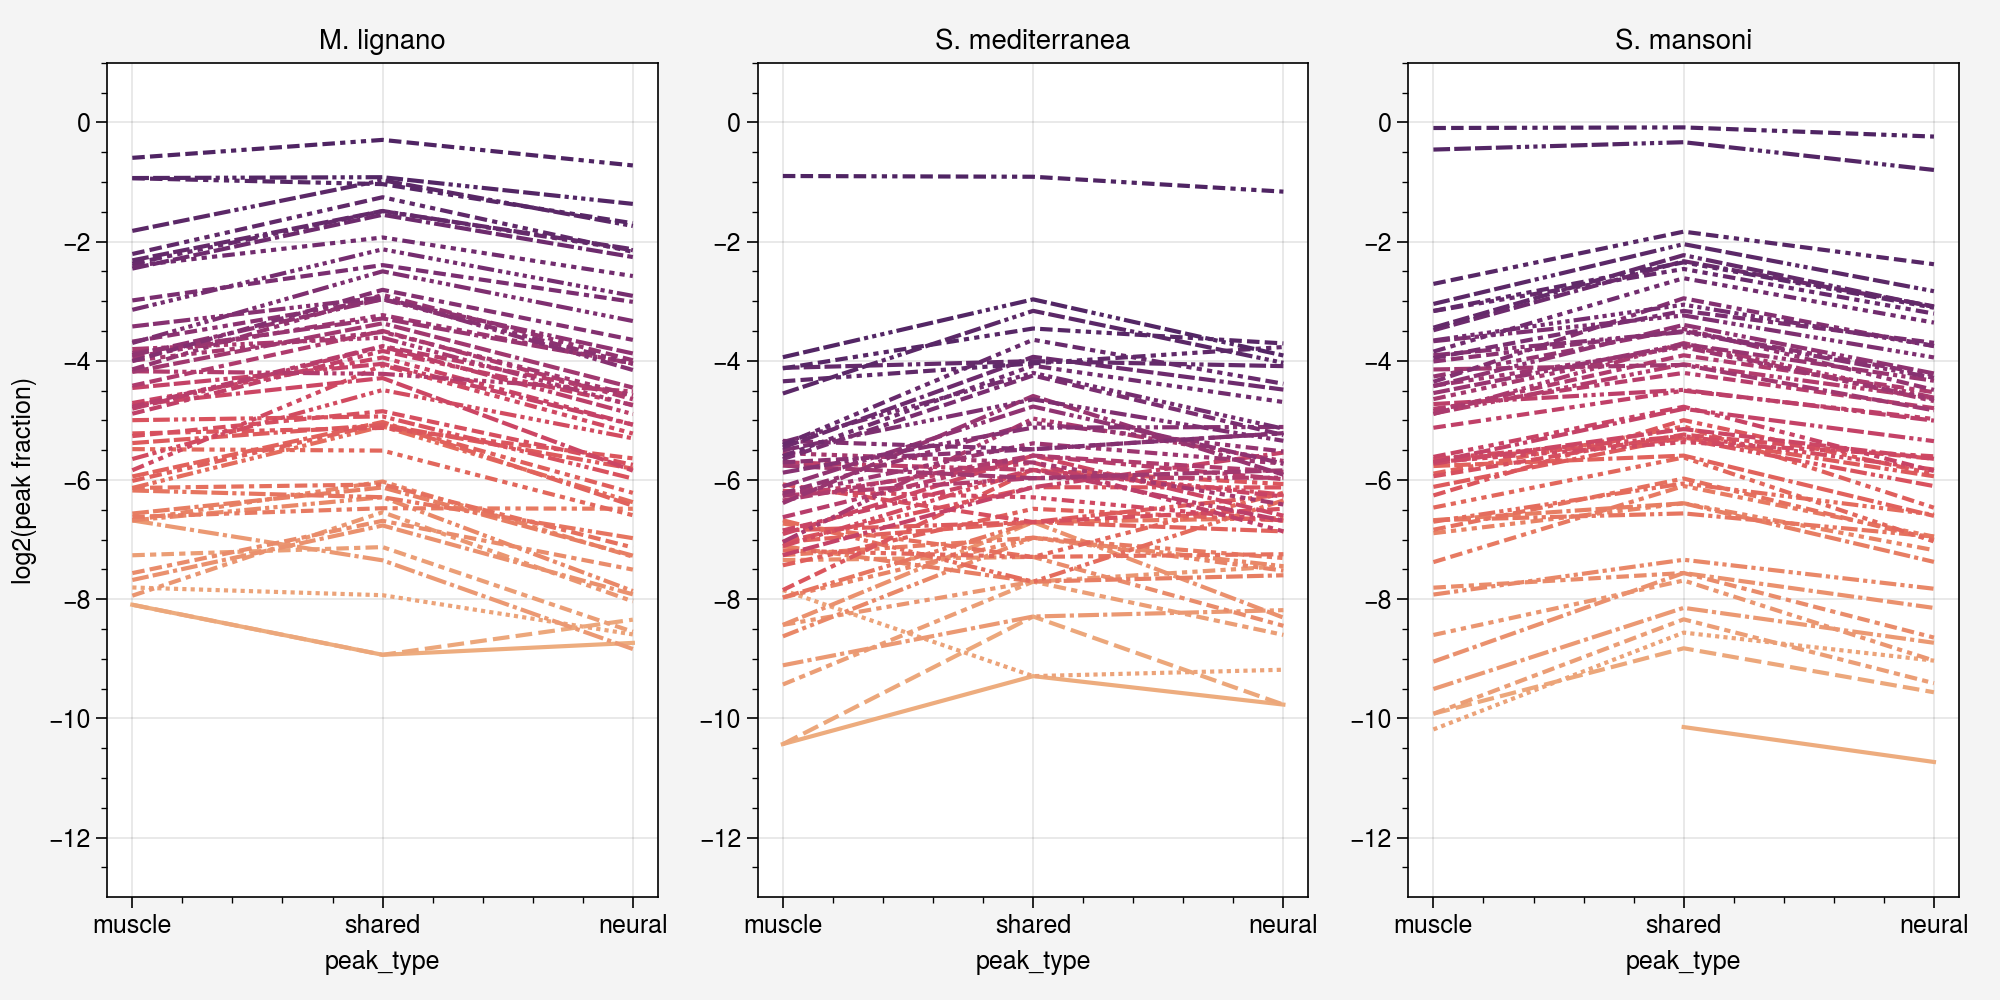

In [111]:
fig, ax = plt.subplots(1,3, figsize=(10, 5))

a= sns.lineplot(data=Mlig.loc[['muscle','shared','neural'],:],ax=ax[0],palette='Flare')
b = sns.lineplot(data=Smed.loc[['muscle','shared','neural'],:],ax=ax[1],palette='Flare')
c = sns.lineplot(data=Sman.loc[['muscle','shared','neural'],:],ax=ax[2],palette = 'Flare')

ax[0].get_legend().set_visible(False)
ax[1].get_legend().set_visible(False)
ax[2].get_legend().set_visible(False)
ax[0].set_ylabel('log2(peak fraction)')
ax[0].set_title('M. lignano')
ax[1].set_title('S. mediterranea')
ax[2].set_title('S. mansoni')
plt.tight_layout()
plt.setp(ax, ylim=(-13,1))
plt.savefig('./Plots/EDFig6/PanelED6c.svg',format='svg')

## Neural-muscle enrichment barplot

In [67]:
neural_motifs = ['JC_0012','JC_0030','JC_0054','JC_0071','JC_0080',
                 'JC_0094','JC_0095','JC_0117','JC_0118','JC_0123',
                 'JC_0147','JC_0165','JC_0178','JC_0190','JC_0192',
                 'JC_0193','JC_0216','JC_0238','JC_0255','JC_0278',
                 'JC_0280','JC_0294','JC_0320','JC_0349','JC_0350',
                 'JC_0352','JC_0368','JC_0381','JC_0393','JC_0397',
                 'JC_0411','JC_0412','JC_0418','WC_0011','WC_0014',
                 'WC_0015','WC_0018','WC_0022','WC_0036','WC_0047',
                 'WC_0113','WC_0116','WC_0149','WC_0171','WC_0194',
                 'WC_0271','WC_0282','WC_0288','WC_0294','WC_0334',
                 'WC_0335','WC_0383','WC_0386','WC_0400','WC_0405',
                 'WC_0416','WC_0469','WC_0472','WC_0474','WC_0478',
                 'WC_0484','WC_0485','WC_0514','WC_0521','WC_0524',
                 'WC_0542','WC_0551','WC_0589','WC_0590','WC_0602',
                 'WC_0611','WC_0612','WC_0613','WC_0614','WC_0618',
                 'WC_0626','WC_0645','WC_0646','WC_0647','WC_0648',
                 'WC_0650','WC_0651','WC_0721','WC_0722','WC_0724',
                 'WC_0727','WC_0755','WC_0761','WC_0765','WC_0782',
                 'WC_0786','WC_0794','WC_0823','WC_0825','WC_0826',
                 'WC_0856','WC_0968','WC_0969','WC_0976','WC_0996',
                 'WC_1013', 'WC_1159','WC_1174','WC_1252','WC_1374',
                 'WC_1590','WC_1784','WC_1803','WC_1919','WC_1968',
                 'WC_1969','WC_1970','WC_1973','WC_1974','WC_1977']

muscle_motifs = ['JC_0033', 'JC_0081','JC_0128', 'JC_0144', 'JC_0198',
                 'JC_0253', 'JC_0358', 'WC_0100','WC_0275', 'WC_1094', 
                 'WC_1652','WC_1727']

### M. lignano

In [99]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)

muscle_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=3550)
muscle_final_sub = muscle_final.sort_values(by='prob_da',ascending=False)
muscle_final_sub = muscle_final_sub.head(n=2500)

merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [105]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak
neural = neural[neural.peak.isin(neural_specific)]
muscle = muscle[muscle.peak.isin(muscle_specific)]
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
muscle = muscle[muscle.peak.isin(muscle_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]


In [90]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered Neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered Muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [89]:
# Count co-occurrences Neural 
import timeit
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0]# species specific peaks in filtered h5ad 
        #print(N)
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2 and (row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_neural_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t")
print(timeit.default_timer() - start_time, "seconds") 

205.317768900999 seconds


In [93]:
# co-occurrence enrichment in muscle
import timeit
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_muscle_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

168.4460970780001 seconds


In [165]:
Mlig_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_neural_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t",index_col=0)

Mlig_neural['JC_0012'] = 1
Mlig_neural['JC_0117'] = 1
Mlig_neural = Mlig_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Mlig_neural_counts = Mlig_neural.to_numpy()

Mlig_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_muscle_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t",index_col=0)
Mlig_muscle = Mlig_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Mlig_muscle_counts = Mlig_muscle.to_numpy()

Mlig_neural_muscle = np.concatenate((Mlig_neural_counts,Mlig_muscle_counts),axis=1)

### S.mediterranea

In [100]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)

muscle_final = pd.read_csv('./ChromBPNet/Peaks/pl_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/pl_Neural_final.csv',sep=',',index_col=0)
merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [106]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak

neural = neural[neural.peak.isin(neural_specific)]
muscle = muscle[muscle.peak.isin(muscle_specific)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [115]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()
muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural 
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered_one
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [116]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_neural_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

170.7138763510011 seconds


In [120]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_muscle_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

101.59037454600002 seconds


In [198]:
Smed_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_neural_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t",index_col=0)
Smed_neural['JC_0165'] = 1
Smed_neural = Smed_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Smed_neural_counts = Smed_neural.to_numpy()

Smed_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_muscle_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t",index_col=0)
motif_notin = 'JC_0238'
new_row = pd.Series(1, index=Smed_muscle.columns, name=motif_notin)
Smed_muscle = Smed_muscle.append(new_row)
Smed_muscle = Smed_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Smed_muscle_counts = Smed_muscle.to_numpy()

Smed_neural_muscle = np.concatenate((Smed_neural_counts,Smed_muscle_counts),axis=1)

/tmp/ipykernel_6799/226968233.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Smed_muscle = Smed_muscle.append(new_row)


### S.mansoni

In [138]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)

muscle_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=2800)
muscle_final_sub = muscle_final.sort_values(by='prob_da',ascending=False)
muscle_final_sub = muscle_final_sub.head(n=1500)

merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [144]:
overlap = intersection(muscle_final.Peak, neural_final.Peak
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak
neural = neural[neural.peak.isin(neural_specific)]
muscle = muscle[muscle.peak.isin(muscle_specific)]
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
muscle = muscle[muscle.peak.isin(muscle_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [152]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [153]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_neural_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

266.3816105250007 seconds


In [157]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_muscle_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

217.72920815399993 seconds


In [162]:
Sman_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_neural_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t",index_col=0)
Sman_neural['JC_0165'] = 0
Sman_neural = Sman_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Sman_neural_counts = Sman_neural.to_numpy()

Sman_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_muscle_enriched_selfcooccur_fixed_7_2_24.tsv",sep="\t",index_col=0)
Sman_muscle['JC_0144'] = 0 
Sman_muscle['JC_0165'] = 0 
Sman_muscle['JC_0198'] = 0
motif_notin = 'JC_0283'
new_row = pd.Series(0, index=Sman_muscle.columns, name=motif_notin)
Sman_muscle = Sman_muscle.append(new_row)
motif_notin2 = 'JC_0305'
new_row2 = pd.Series(0, index=Sman_muscle.columns, name=motif_notin2)
Sman_muscle = Sman_muscle.append(new_row2)
# motif_notin3 = 'JC_0198'
# new_row3 = pd.Series(1, index=Sman_muscle.columns, name=motif_notin3)
# Sman_muscle = Sman_muscle.append(new_row3)
Sman_muscle = Sman_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Sman_muscle_counts = Sman_muscle.to_numpy()

Sman_neural_muscle = np.concatenate((Sman_neural_counts,Sman_muscle_counts),axis=1)

/tmp/ipykernel_6799/1574367451.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Sman_muscle = Sman_muscle.append(new_row)
/tmp/ipykernel_6799/1574367451.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Sman_muscle = Sman_muscle.append(new_row2)


/tmp/ipykernel_6799/1881804426.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Value', data=df, ax=ax, palette='viridis')


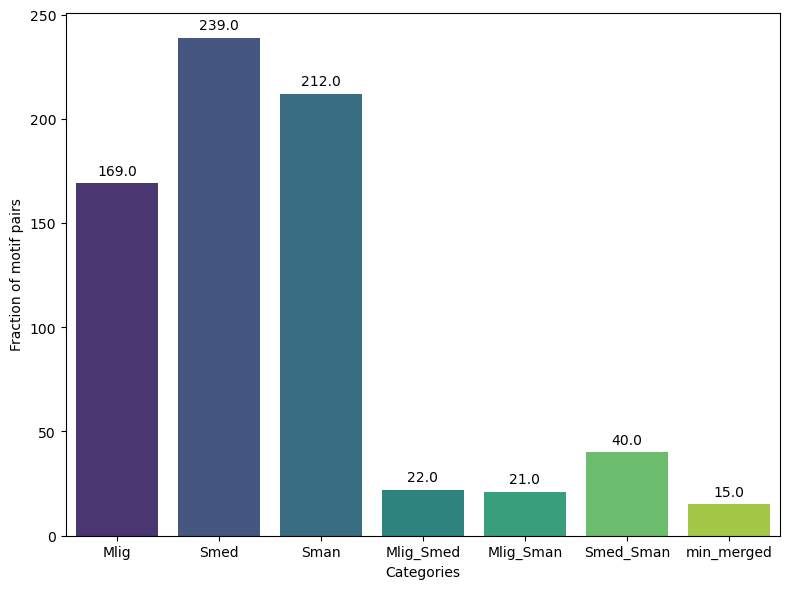

In [207]:
min_merged = np.concatenate((Mlig_neural_muscle[:,:,None],Smed_neural_muscle[:,:,None],Sman_neural_muscle[:,:,None]),axis=2).min(2)
min_Mlig_Smed = np.concatenate((Mlig_neural_muscle[:,:,None],Smed_neural_muscle[:,:,None]),axis=2).min(2)
min_Mlig_Sman = np.concatenate((Mlig_neural_muscle[:,:,None],Sman_neural_muscle[:,:,None]),axis=2).min(2)
min_Smed_Sman = np.concatenate((Smed_neural_muscle[:,:,None],Sman_neural_muscle[:,:,None]),axis=2).min(2)

thres = 4
Mlig_neural_muscle_sum = (Mlig_neural_muscle > thres).sum()
Smed_neural_muscle_sum = (Smed_neural_muscle > thres).sum()
Sman_neural_muscle_sum = (Sman_neural_muscle > thres).sum()
Mlig_Smed_min = (min_Mlig_Smed > thres).sum()
Mlig_Sman_min = (min_Mlig_Sman > thres).sum()
Smed_Sman_min = (min_Smed_Sman > thres).sum()
min_merged_sum = (min_merged > thres).sum()

data = {
    'Category': ['Mlig', 'Smed', 'Sman', 'Mlig_Smed','Mlig_Sman', 'Smed_Sman', 'min_merged'],
    'Value': [Mlig_neural_muscle_sum, Smed_neural_muscle_sum, Sman_neural_muscle_sum, Mlig_Smed_min,
              Mlig_Sman_min, Smed_Sman_min,min_merged_sum]
}
df = pd.DataFrame(data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create bar plot using Seaborn
sns.barplot(x='Category', y='Value', data=df, ax=ax, palette='viridis')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Add titles and labels
ax.set_xlabel('Categories')
ax.set_ylabel('Fraction of motif pairs')

# Show plot
plt.tight_layout()
plt.savefig("./Plots/Fig3/Panel3c_top.svg")
plt.show()

## SHAP filtered cooccurrence extended data only for very specific neural and muscle family motifs

In [ ]:
neural_motifs = ['JC_0012', 'JC_0028', 'JC_0030', 'JC_0117', 'JC_0147',
                 'JC_0165','JC_0178', 'JC_0192', 'JC_0193','JC_0255', 
                 'JC_0278','JC_0280', 'JC_0320', 'JC_0411','WC_0011',
                 'WC_0047','WC_0194', 'WC_0335', 'WC_0400','WC_0472',
                 'WC_0474','WC_0651', 'WC_0721','WC_0722', 'WC_0727', 
                 'WC_0761','WC_0968', 'WC_0996', 'WC_1013','WC_1174', 
                 'WC_1302', 'WC_1784','WC_1919']

muscle_motifs = ['JC_0128', 'JC_0253', 'WC_0100', 'WC_0275', 'WC_1094', 'WC_1652','WC_1727']

### M. lignano

In [74]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)

muscle_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=3550)
muscle_final_sub = muscle_final.sort_values(by='prob_da',ascending=False)
muscle_final_sub = muscle_final_sub.head(n=2500)

merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [80]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak

muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak

neural = neural[neural.peak.isin(neural_specific)]
muscle = muscle[muscle.peak.isin(muscle_specific)]
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
muscle = muscle[muscle.peak.isin(muscle_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [90]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered Neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered Muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [89]:
# Count co-occurrences Neural 
import timeit
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0]# species specific peaks in filtered h5ad 
        #print(N)
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2 and (row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_neural_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t")
print(timeit.default_timer() - start_time, "seconds") 

205.317768900999 seconds


In [93]:
# co-occurrence enrichment in muscle
import timeit
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_muscle_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

168.4460970780001 seconds


In [98]:
Mlig_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_neural_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t",index_col=0)

Mlig_neural['JC_0012'] = 1
Mlig_neural['JC_0117'] = 1
Mlig_neural = Mlig_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Mlig_neural_counts = Mlig_neural.to_numpy()

Mlig_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_muscle_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t",index_col=0)
Mlig_muscle = Mlig_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Mlig_muscle_counts = Mlig_muscle.to_numpy()

Mlig_neural_muscle = np.concatenate((Mlig_neural_counts,Mlig_muscle_counts),axis=1)

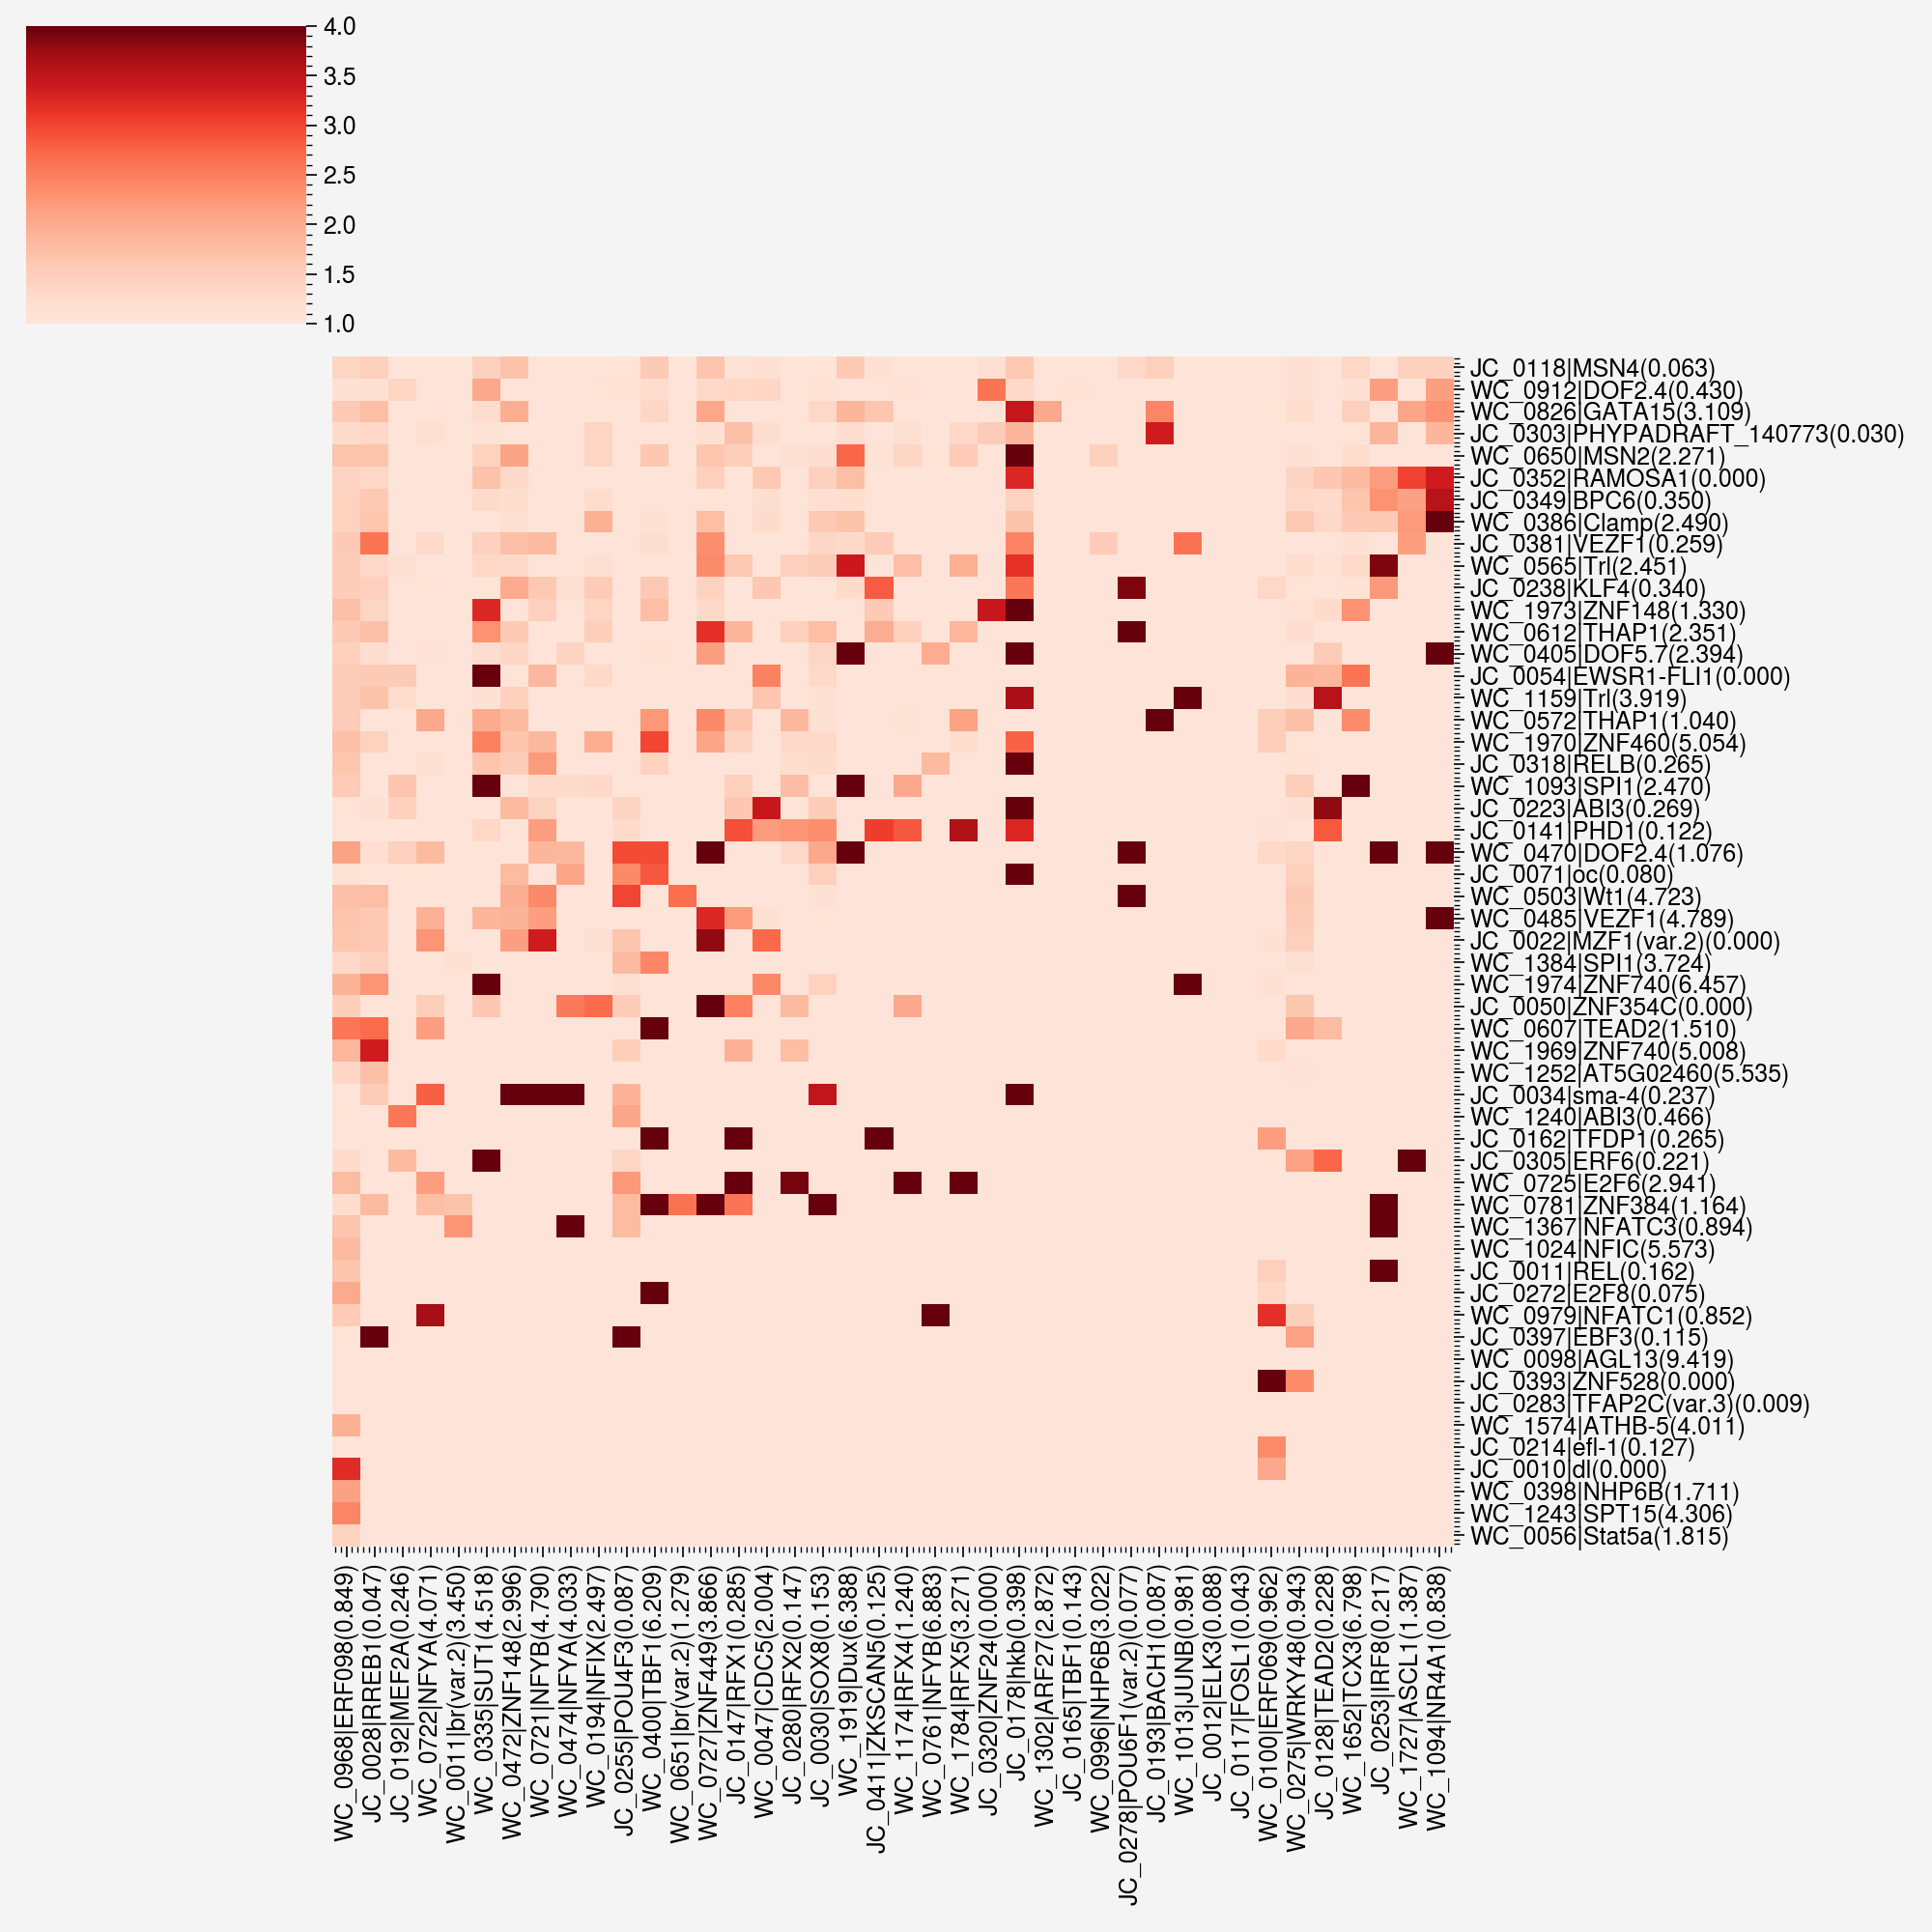

In [99]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Mlig_heatmap = sns.clustermap(Mlig_neural_muscle,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Mlig_heatmap.ax_heatmap.set_xticks(np.arange(Mlig_neural_muscle.shape[1])+0.5)
Mlig_heatmap.ax_heatmap.set_yticks(np.arange(Mlig_neural_muscle.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

Mlig_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
Mlig_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6d_Mlig.svg",format="svg")
plt.show()

### S. mediterranea

In [100]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)

muscle_final = pd.read_csv('./ChromBPNet/Peaks/pl_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/pl_Neural_final.csv',sep=',',index_col=0)
merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [106]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak

neural = neural[neural.peak.isin(neural_specific)]
muscle = muscle[muscle.peak.isin(muscle_specific)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [115]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()
muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural 
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered_one
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [116]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_neural_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

170.7138763510011 seconds


In [120]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_muscle_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

101.59037454600002 seconds


In [135]:
Smed_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_neural_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t",index_col=0)
Smed_neural['JC_0165'] = 1
Smed_neural = Smed_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Smed_neural_counts = Smed_neural.to_numpy()

Smed_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_muscle_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t",index_col=0)
motif_notin = 'JC_0238'
new_row = pd.Series(1, index=Smed_muscle.columns, name=motif_notin)
Smed_muscle = Smed_muscle.append(new_row)
Smed_muscle = Smed_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Smed_muscle_counts = Smed_muscle.to_numpy()

Smed_neural_muscle = np.concatenate((Smed_neural_counts,Smed_muscle_counts),axis=1)

/tmp/ipykernel_6986/506161932.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Smed_muscle = Smed_muscle.append(new_row)


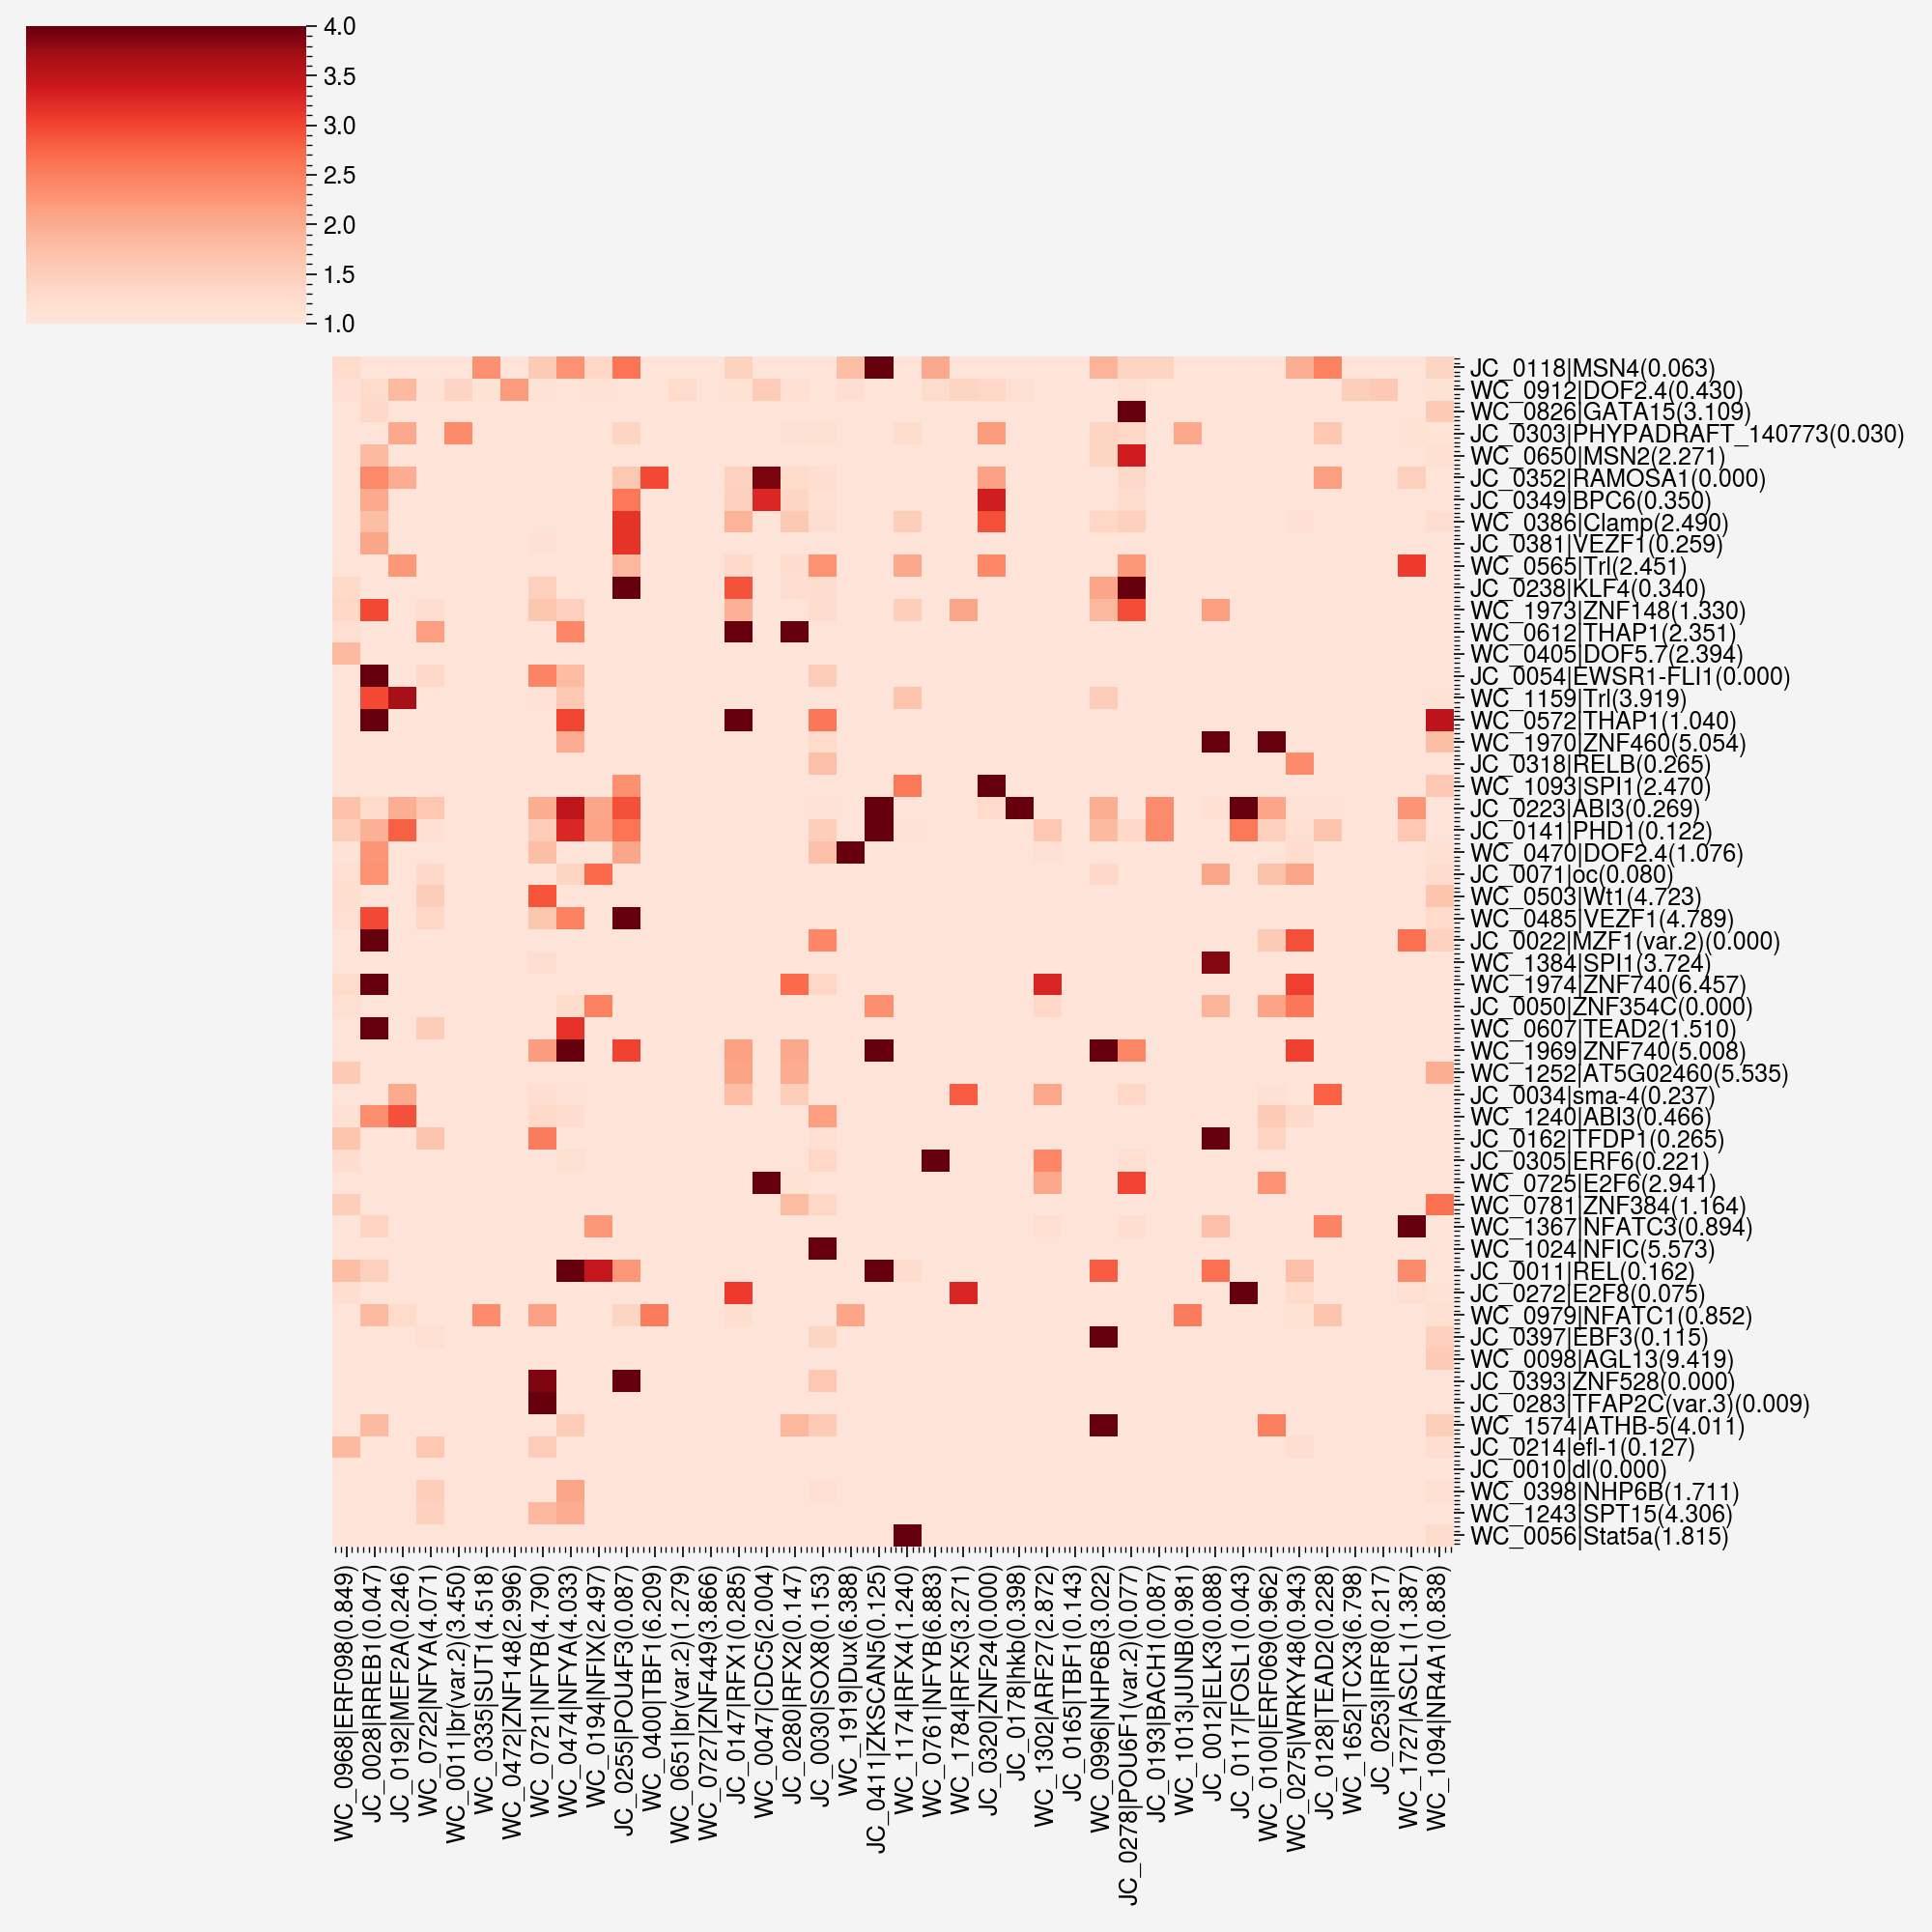

In [137]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Smed_heatmap = sns.clustermap(Smed_neural_muscle,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Smed_heatmap.ax_heatmap.set_xticks(np.arange(Smed_neural_muscle.shape[1])+0.5)
Smed_heatmap.ax_heatmap.set_yticks(np.arange(Smed_neural_muscle.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

Smed_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
Smed_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6d_Smed.svg",format="svg")
plt.show()

### S. mansoni

In [138]:
muscle = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/muscle_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
muscle['peak'] = muscle.peak_chrom + ':' + (muscle.peak_start+1).astype(str) + '-' + muscle.peak_end.astype(str)

muscle_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=2800)
muscle_final_sub = muscle_final.sort_values(by='prob_da',ascending=False)
muscle_final_sub = muscle_final_sub.head(n=1500)

merged_neural_muscle = [muscle_final,neural_final]
merged_neural_muscle = pd.concat(merged_neural_muscle)
merged_neural_muscle = merged_neural_muscle.drop_duplicates(subset="Peak",keep='first')

In [144]:
overlap = intersection(muscle_final.Peak, neural_final.Peak
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak
neural = neural[neural.peak.isin(neural_specific)]
muscle = muscle[muscle.peak.isin(muscle_specific)]
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
muscle = muscle[muscle.peak.isin(muscle_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [152]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [153]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_neural_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

266.3816105250007 seconds


In [157]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_muscle_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

217.72920815399993 seconds


In [171]:
Sman_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_neural_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t",index_col=0)
Sman_neural['JC_0165'] = 1
Sman_neural = Sman_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Sman_neural_counts = Sman_neural.to_numpy()

Sman_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_muscle_enriched_selfcooccur_fixed_5_22_24.tsv",sep="\t",index_col=0)
motif_notin = 'JC_0283'
new_row = pd.Series(1, index=Sman_muscle.columns, name=motif_notin)
Sman_muscle = Sman_muscle.append(new_row)
motif_notin2 = 'JC_0305'
new_row2 = pd.Series(1, index=Sman_muscle.columns, name=motif_notin2)
Sman_muscle = Sman_muscle.append(new_row2)
Sman_muscle = Sman_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Sman_muscle_counts = Sman_muscle.to_numpy()

Sman_neural_muscle = np.concatenate((Sman_neural_counts,Sman_muscle_counts),axis=1)

/tmp/ipykernel_6986/3775101157.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Sman_muscle = Sman_muscle.append(new_row)
/tmp/ipykernel_6986/3775101157.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Sman_muscle = Sman_muscle.append(new_row2)


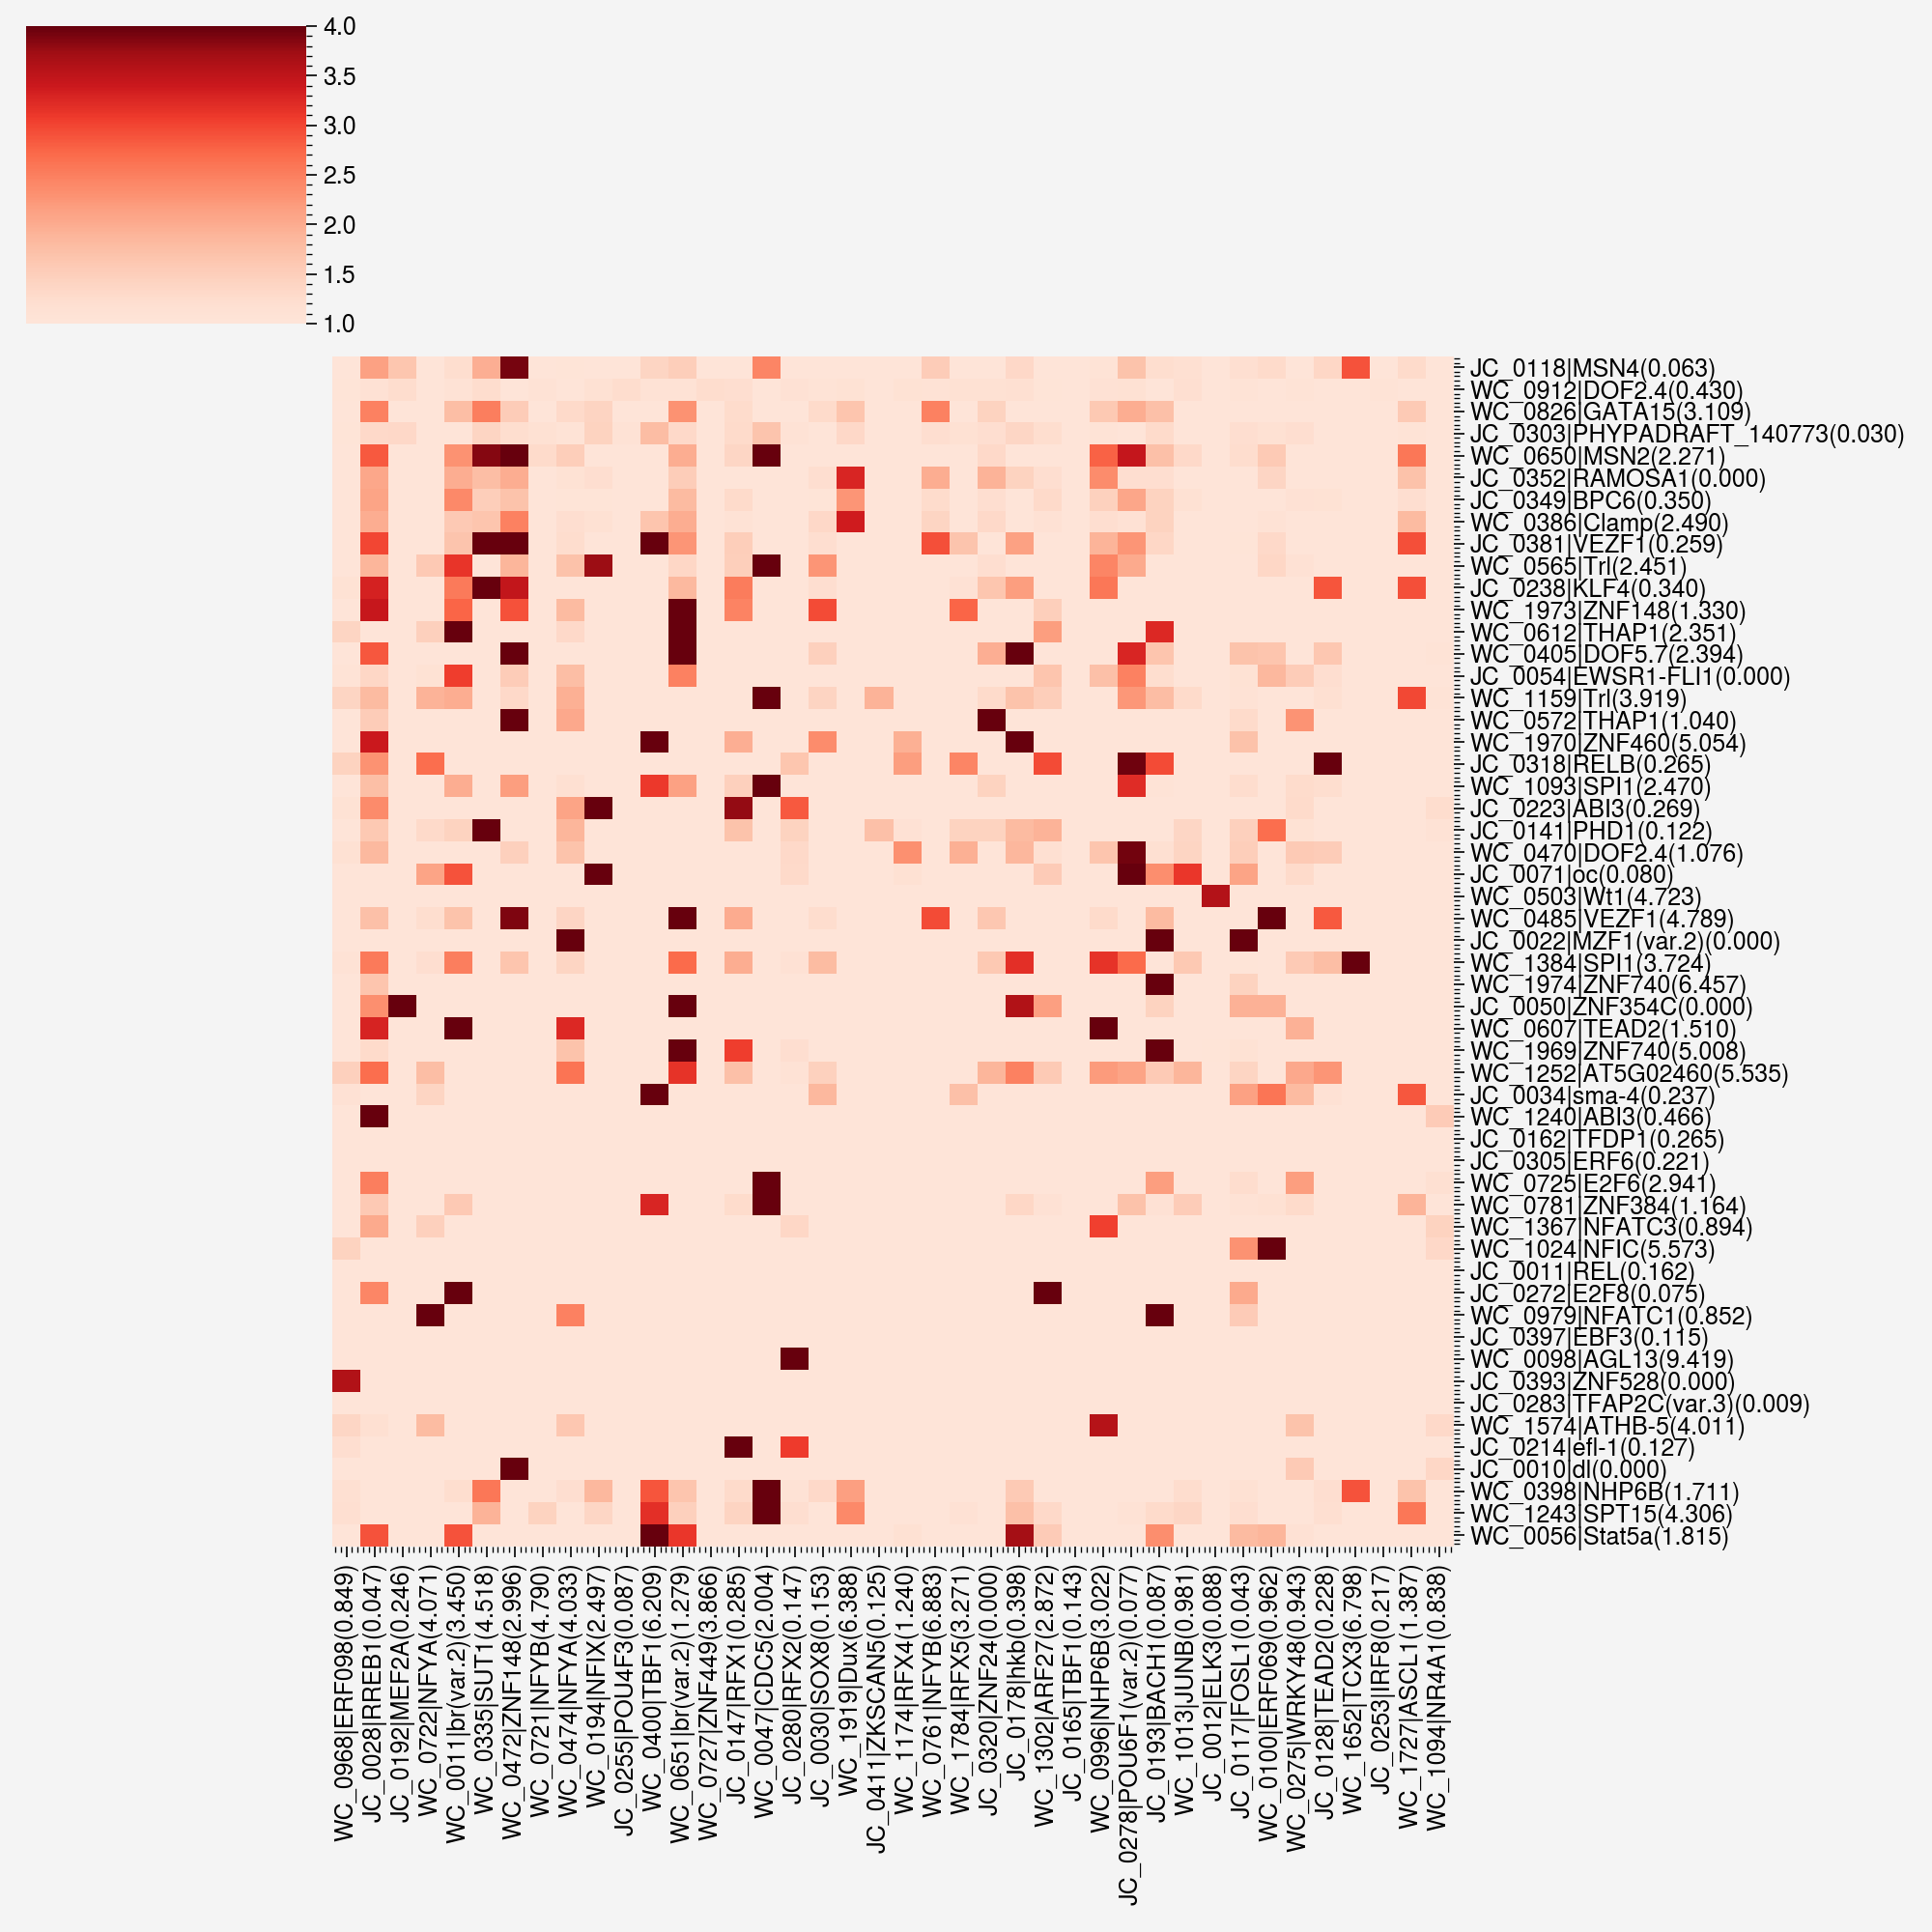

In [173]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Sman_heatmap = sns.clustermap(Sman_neural_muscle,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Sman_heatmap.ax_heatmap.set_xticks(np.arange(Sman_neural_muscle.shape[1])+0.5)
Sman_heatmap.ax_heatmap.set_yticks(np.arange(Sman_neural_muscle.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

Sman_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
Sman_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6d_Sman.svg",format="svg")
plt.show()

### Minimum across all three flatworms

In [174]:
min_merged = np.concatenate((Mlig_neural_muscle[:,:,None],Smed_neural_muscle[:,:,None],Sman_neural_muscle[:,:,None]),axis=2).min(2)

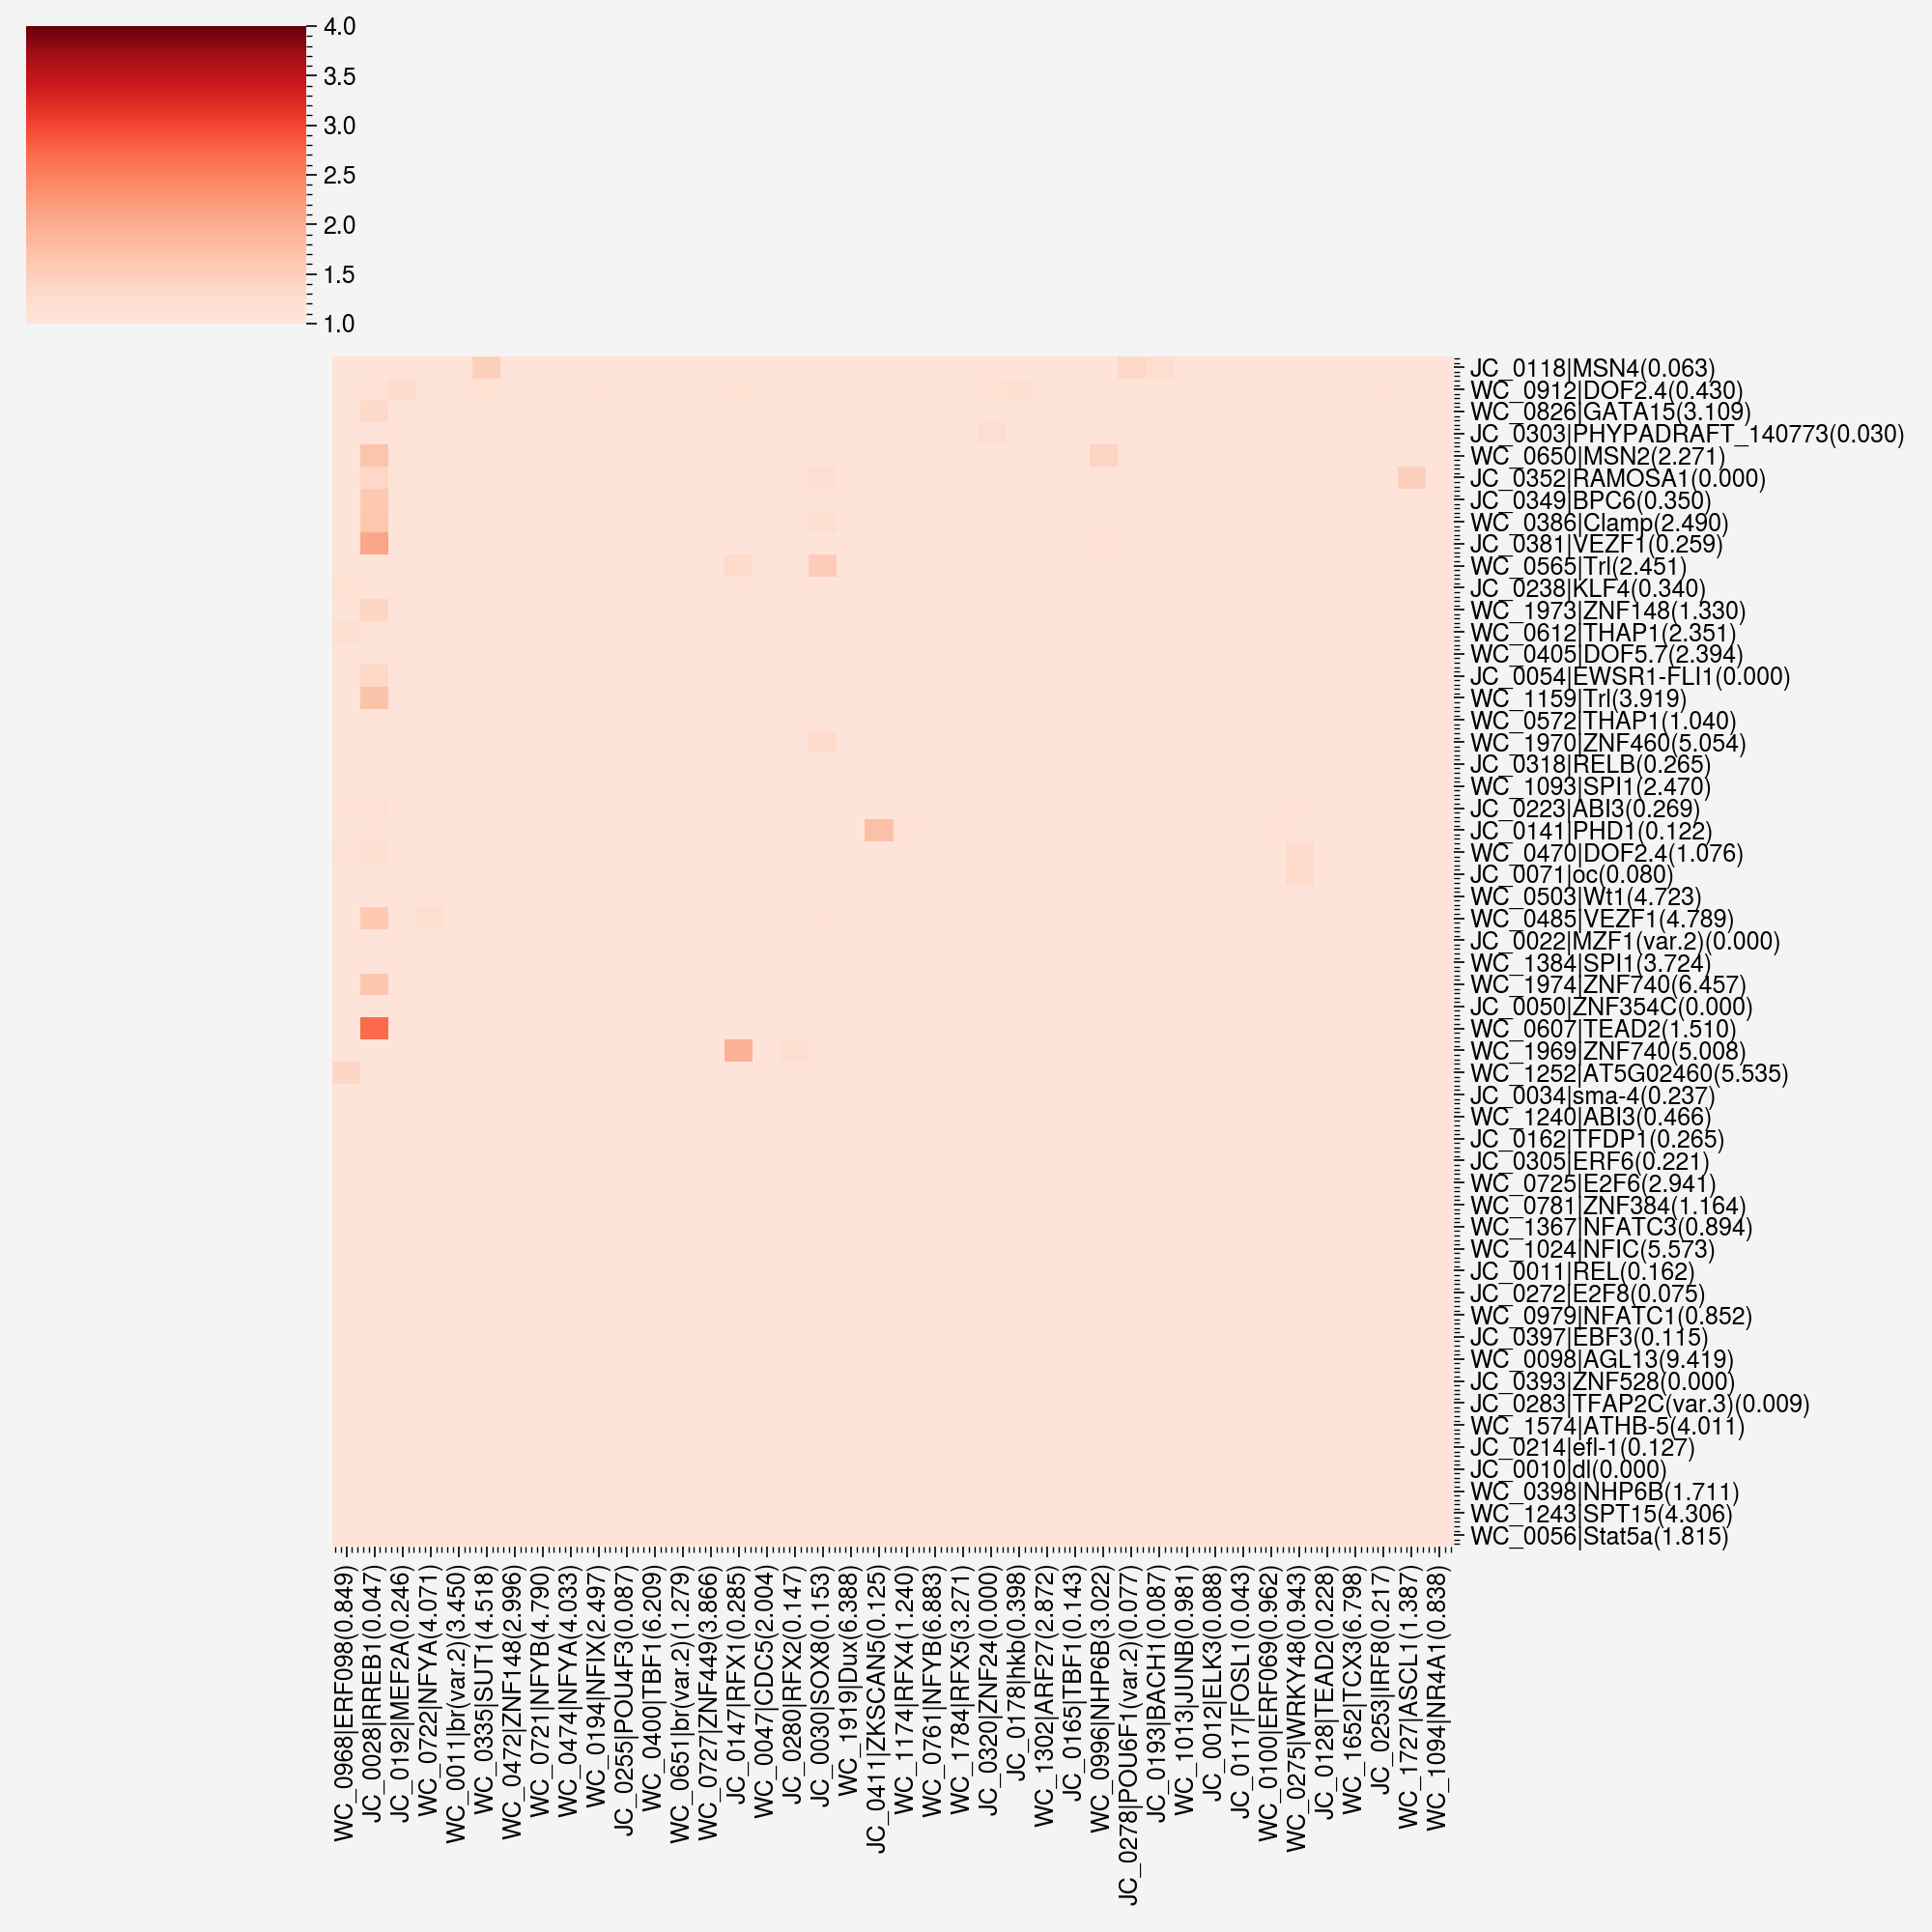

In [177]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
minimum_heatmap = sns.clustermap(min_merged,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
minimum_heatmap.ax_heatmap.set_xticks(np.arange(min_merged.shape[1])+0.5)
minimum_heatmap.ax_heatmap.set_yticks(np.arange(min_merged.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

minimum_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
minimum_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6d_minimum.svg",format="svg")
plt.show()

## SHAP unfiltered cooccurrence extended data

### M.lignano

In [47]:
motif_anno = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/Mlig.peak_Motifhits_20230130_selfcooccur.tsv',sep="\t")
motif_anno['peak'] = motif_anno.peak_chrom + ':' + (motif_anno.peak_start+1).astype(str) + '-' + motif_anno.peak_end.astype(str)
muscle_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=3550)
muscle_final_sub = muscle_final.sort_values(by='prob_da',ascending=False)
muscle_final_sub = muscle_final_sub.head(n=2500)

In [51]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak
neural = motif_anno[motif_anno.peak.isin(neural_specific)]
muscle = motif_anno[motif_anno.peak.isin(muscle_specific)]
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
muscle = muscle[muscle.peak.isin(muscle_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [68]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)


In [69]:
# Unfiltered co-occurrrence enrichment neural 
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0]# species specific peaks in filtered h5ad 
        #print(N)
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2 and (row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_neural_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds")

1668.9090267020001 seconds


In [73]:
# Unfiltered cooccurrence enrichment muscle 
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_muscle_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

1086.0647627090002 seconds


In [74]:
Mlig_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_neural_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t",index_col=0)
Mlig_neural = Mlig_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Mlig_neural_counts = Mlig_neural.to_numpy()

Mlig_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/shared_motifs_muscle_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t",index_col=0)
Mlig_muscle = Mlig_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Mlig_muscle_counts = Mlig_muscle.to_numpy()

Mlig_neural_muscle = np.concatenate((Mlig_neural_counts,Mlig_muscle_counts),axis=1)

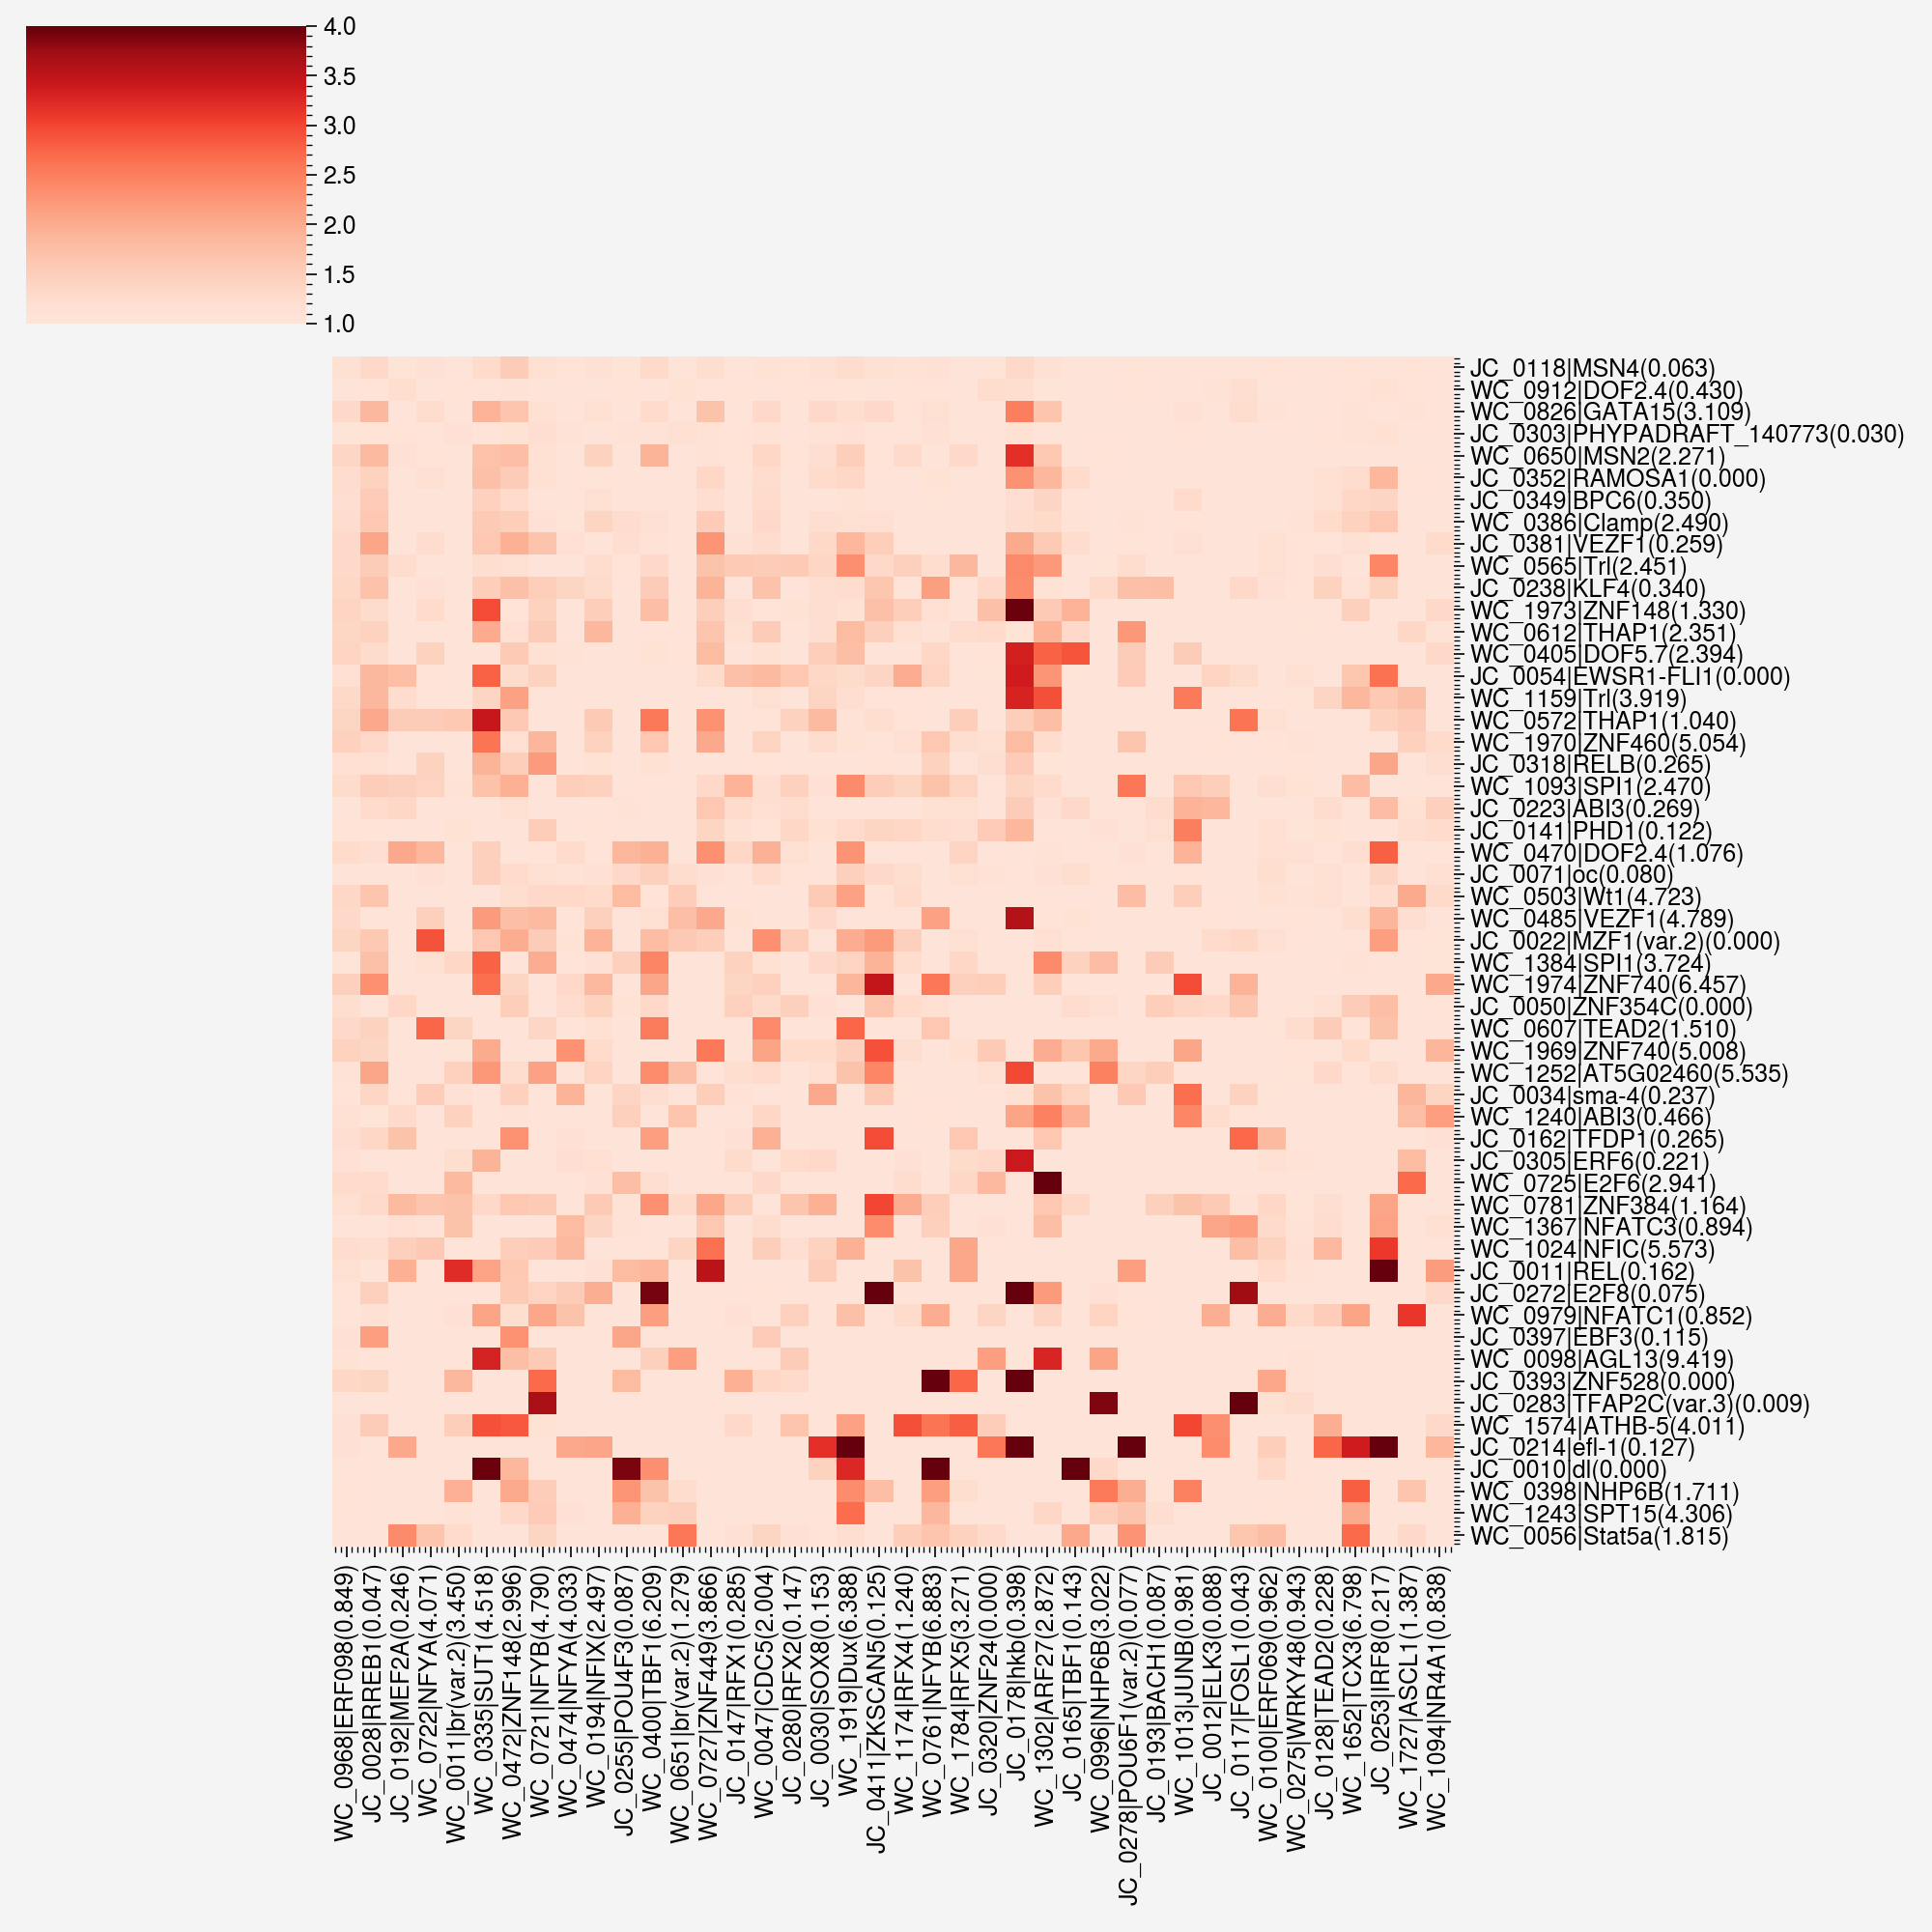

In [75]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Mlig_heatmap = sns.clustermap(Mlig_neural_muscle,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Mlig_heatmap.ax_heatmap.set_xticks(np.arange(Mlig_neural_muscle.shape[1])+0.5)
Mlig_heatmap.ax_heatmap.set_yticks(np.arange(Mlig_neural_muscle.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

Mlig_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
Mlig_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6e_Mlig.svg",format="svg")
plt.show()

### S. mediterranea

In [94]:
motif_anno = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/Smed.peak_Motifhits_20230130_selfcooccur.tsv',sep="\t")
motif_anno['peak'] = motif_anno.peak_chrom + ':' + (motif_anno.peak_start+1).astype(str) + '-' + motif_anno.peak_end.astype(str)
muscle_final = pd.read_csv('./ChromBPNet/Peaks/pl_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/pl_Neural_final.csv',sep=',',index_col=0)

In [98]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak
neural = motif_anno[motif_anno.peak.isin(neural_specific)]
muscle = motif_anno[motif_anno.peak.isin(muscle_specific)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [106]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered_muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [107]:
## Unfiltered co-occurrence enrichment in neural 
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_neural_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

1418.6491125069952 seconds


In [111]:
## Unfiltered co-occurrence enrichment in muscle
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_muscle_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

1251.5363064859994 seconds


In [115]:
Smed_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_neural_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t",index_col=0)
Smed_neural = Smed_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Smed_neural_counts = Smed_neural.to_numpy()

Smed_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/shared_motifs_muscle_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t",index_col=0)
Smed_muscle = Smed_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Smed_muscle_counts = Smed_muscle.to_numpy()

Smed_neural_muscle = np.concatenate((Smed_neural_counts,Smed_muscle_counts),axis=1)

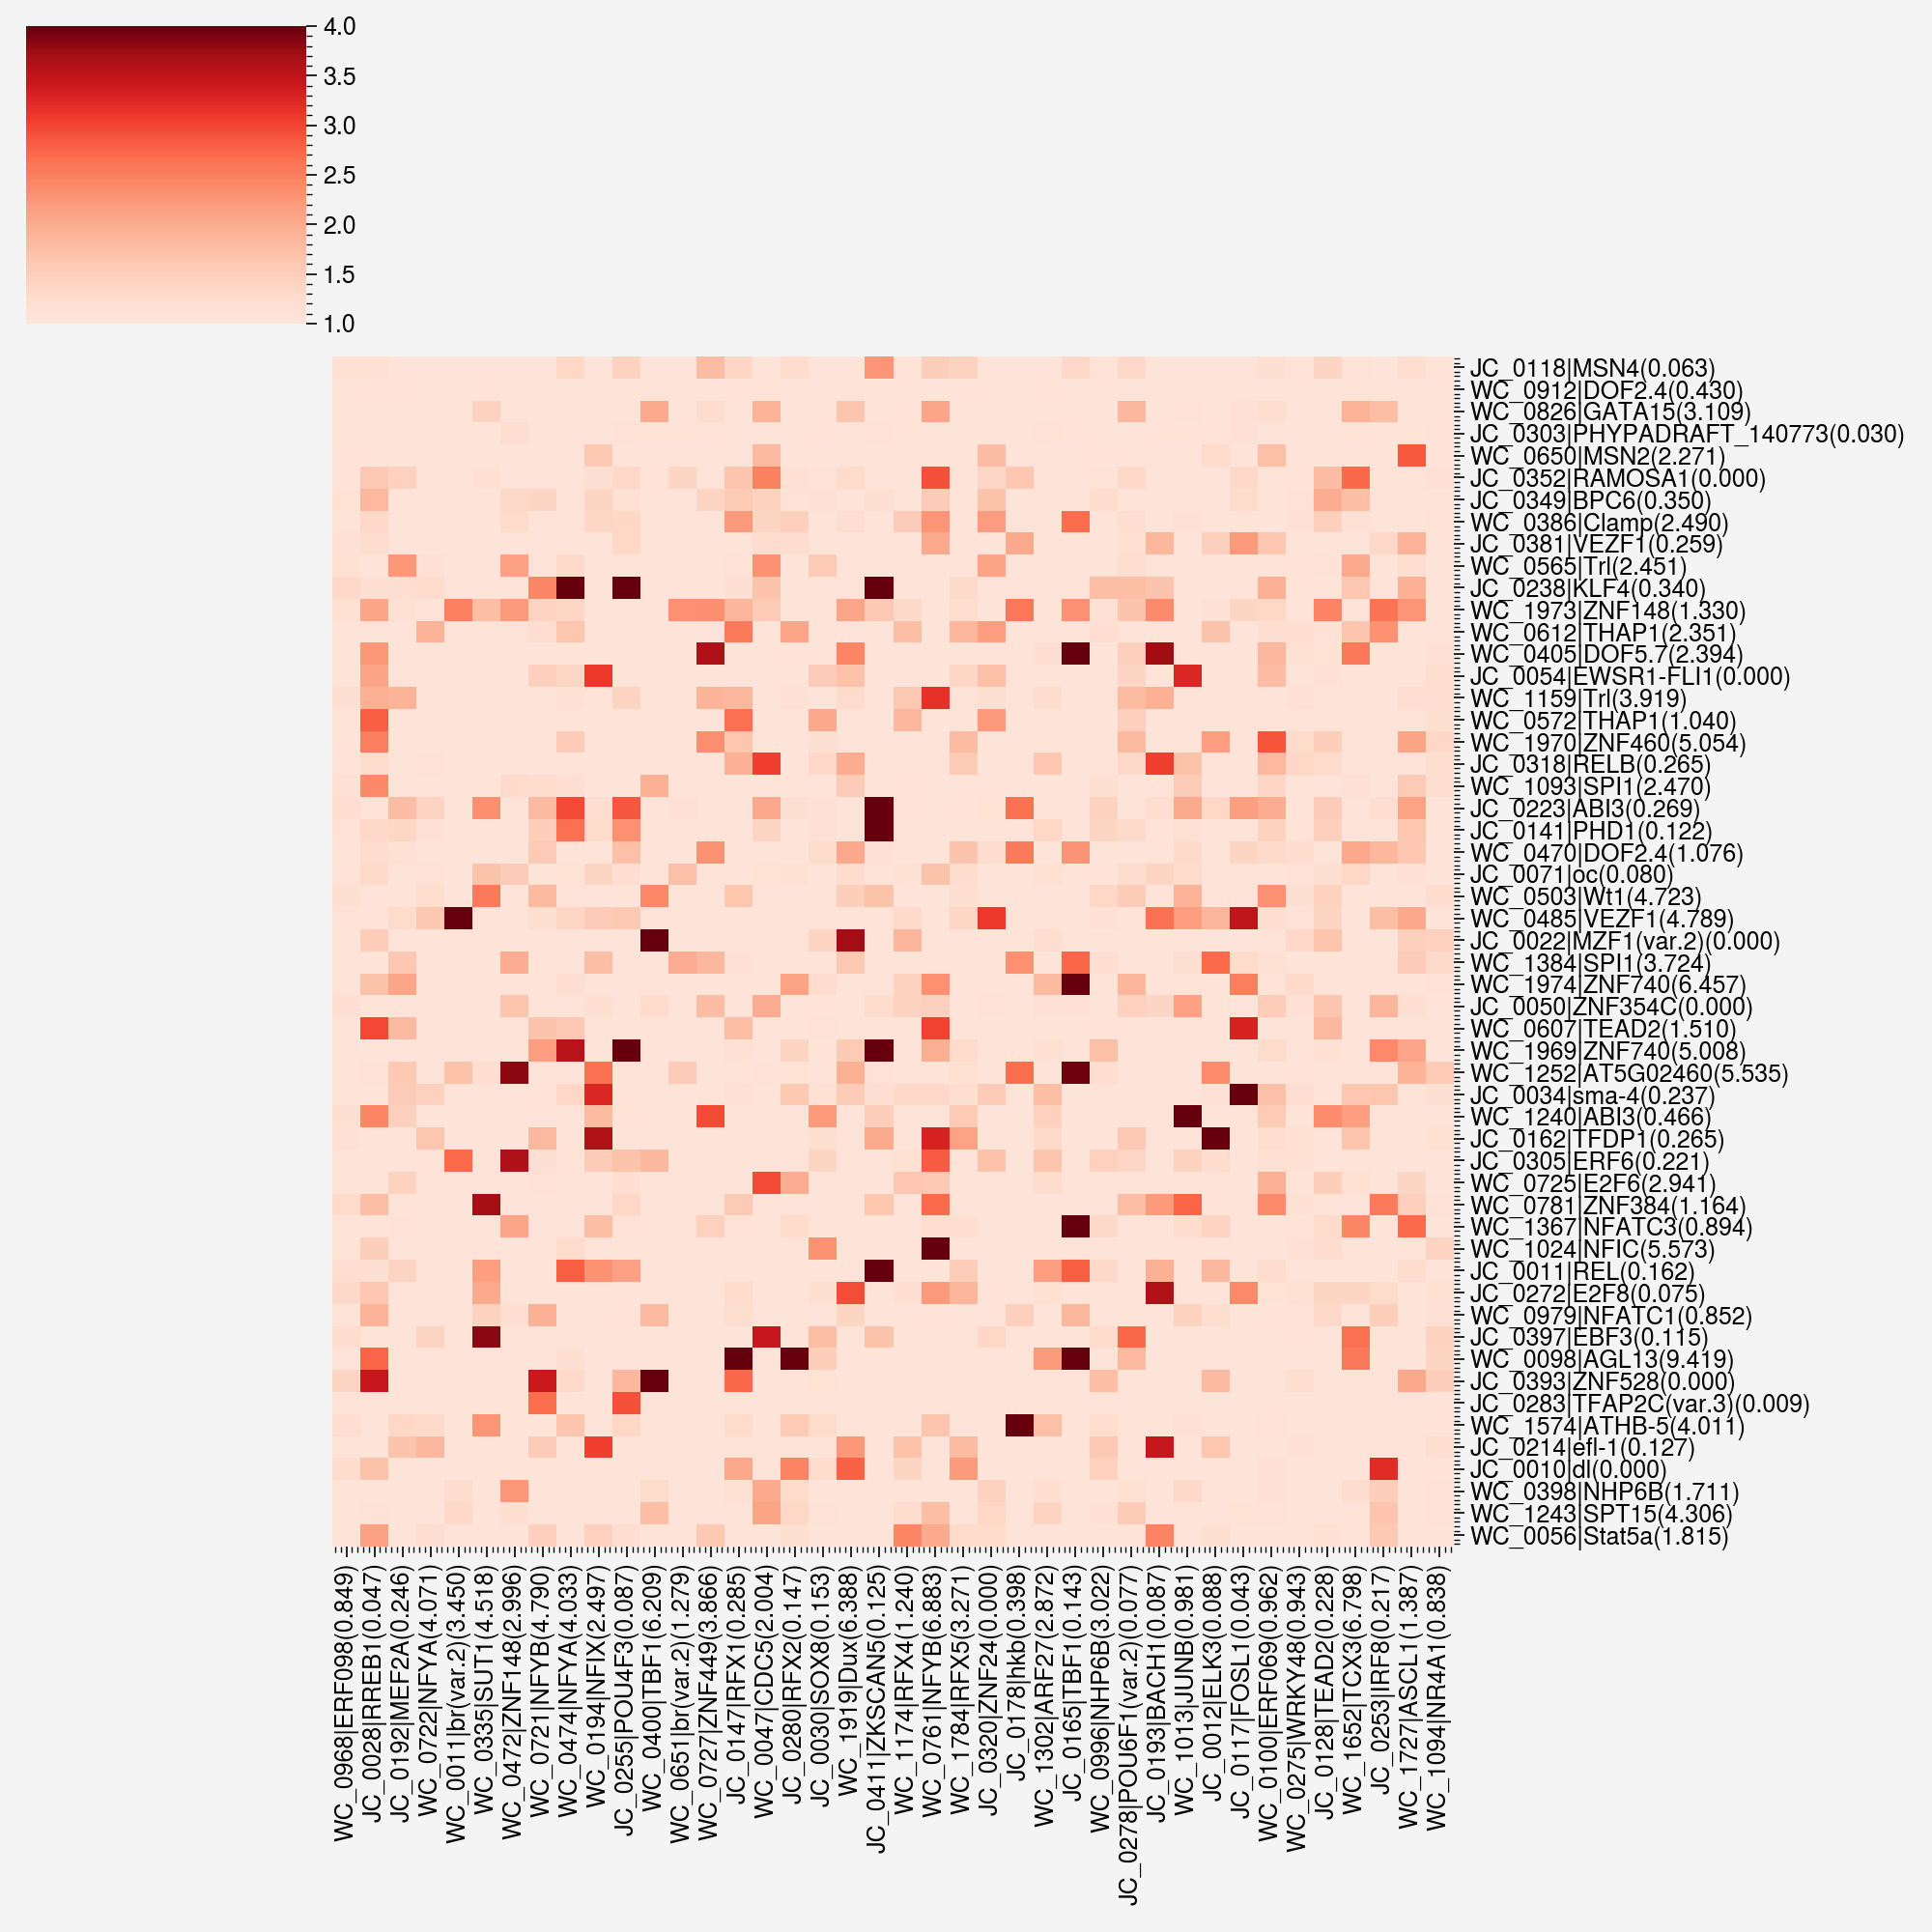

In [77]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Smed_heatmap = sns.clustermap(Smed_neural_muscle,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Smed_heatmap.ax_heatmap.set_xticks(np.arange(Smed_neural_muscle.shape[1])+0.5)
Smed_heatmap.ax_heatmap.set_yticks(np.arange(Smed_neural_muscle.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

Smed_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
Smed_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6e_Smed.svg",format="svg")
plt.show()

### S. mansoni

In [47]:
motif_anno = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/Sman.peak_Motifhits_20230130_selfcooccur.tsv',sep="\t")
motif_anno['peak'] = motif_anno.peak_chrom + ':' + (motif_anno.peak_start+1).astype(str) + '-' + motif_anno.peak_end.astype(str)
muscle_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Muscle_final.csv',sep=',',index_col=0)
neural_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=2800)
muscle_final_sub = muscle_final.sort_values(by='prob_da',ascending=False)
muscle_final_sub = muscle_final_sub.head(n=1500)

In [52]:
overlap = intersection(muscle_final.Peak, neural_final.Peak)
neural_specific = neural_final[~neural_final.Peak.isin(overlap)]
neural_specific = neural_specific.Peak
muscle_specific = muscle_final[~muscle_final.Peak.isin(overlap)]
muscle_specific = muscle_specific.Peak
neural = motif_anno[motif_anno.peak.isin(neural_specific)]
muscle = motif_anno[motif_anno.peak.isin(muscle_specific)]
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
muscle = muscle[muscle.peak.isin(muscle_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]
muscle_sub = muscle[["peak", "start","end","key"]]

In [60]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

muscle_sub_table = muscle_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
muscle_sub_counts = muscle_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

unfiltered_muscle = unfiltered_count_co_occurrences(muscle_sub_counts)
unfiltered_muscle = pd.DataFrame(unfiltered_muscle)
unfiltered_muscle.index = muscle_sub_table.columns.tolist()
unfiltered_muscle.columns = muscle_sub_table.columns.tolist()

## UnFiltered neural
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

## UnFiltered muscle
co_occurrences_df = unfiltered_muscle
motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_unfiltered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)


In [61]:
## Unfiltered co-occurrence enrichment in neural
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(shared_motifs)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(neural_motifs)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_neural_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t")
print(timeit.default_timer() - start_time, "seconds") 

2197.9608566660027 seconds


In [65]:
## Unfiltered co-occurrence enrichment in muscle
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(muscle_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=muscle_sub['key'].unique(), columns=muscle_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

muscle = muscle_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
muscle_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
muscle_long.columns = ['motif_1','motif_2','Num_Peaks']
muscle_l1 = muscle_long[muscle_long["motif_1"].isin(shared_motifs)]
muscle_l1_l2 = muscle_l1[muscle_l1["motif_2"].isin(muscle_motifs)]
muscle_filtered_n = pd.pivot(muscle_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = muscle_unfiltered_n.sub(muscle_filtered_n)

for index,row in muscle_filtered_n.iterrows():
    for motif in muscle_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = muscle.loc[motif1].shape[0] -  delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = muscle.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(muscle_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        muscle_filtered_n.at[index,motif] = frac
muscle_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_muscle_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

1798.8934881809982 seconds


In [78]:
Sman_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_neural_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t",index_col=0)
Sman_neural = Sman_neural.loc[Mlig.index,Mlig_neural_abundance.key]
Sman_neural_counts = Sman_neural.to_numpy()

Sman_muscle = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/shared_motifs_muscle_enriched_selfcooccur_fixed_unfiltered.tsv",sep="\t",index_col=0)
Sman_muscle = Sman_muscle.loc[Mlig.index,Mlig_muscle_abundance.key]
Sman_muscle_counts = Sman_muscle.to_numpy()

Sman_neural_muscle = np.concatenate((Sman_neural_counts,Sman_muscle_counts),axis=1)

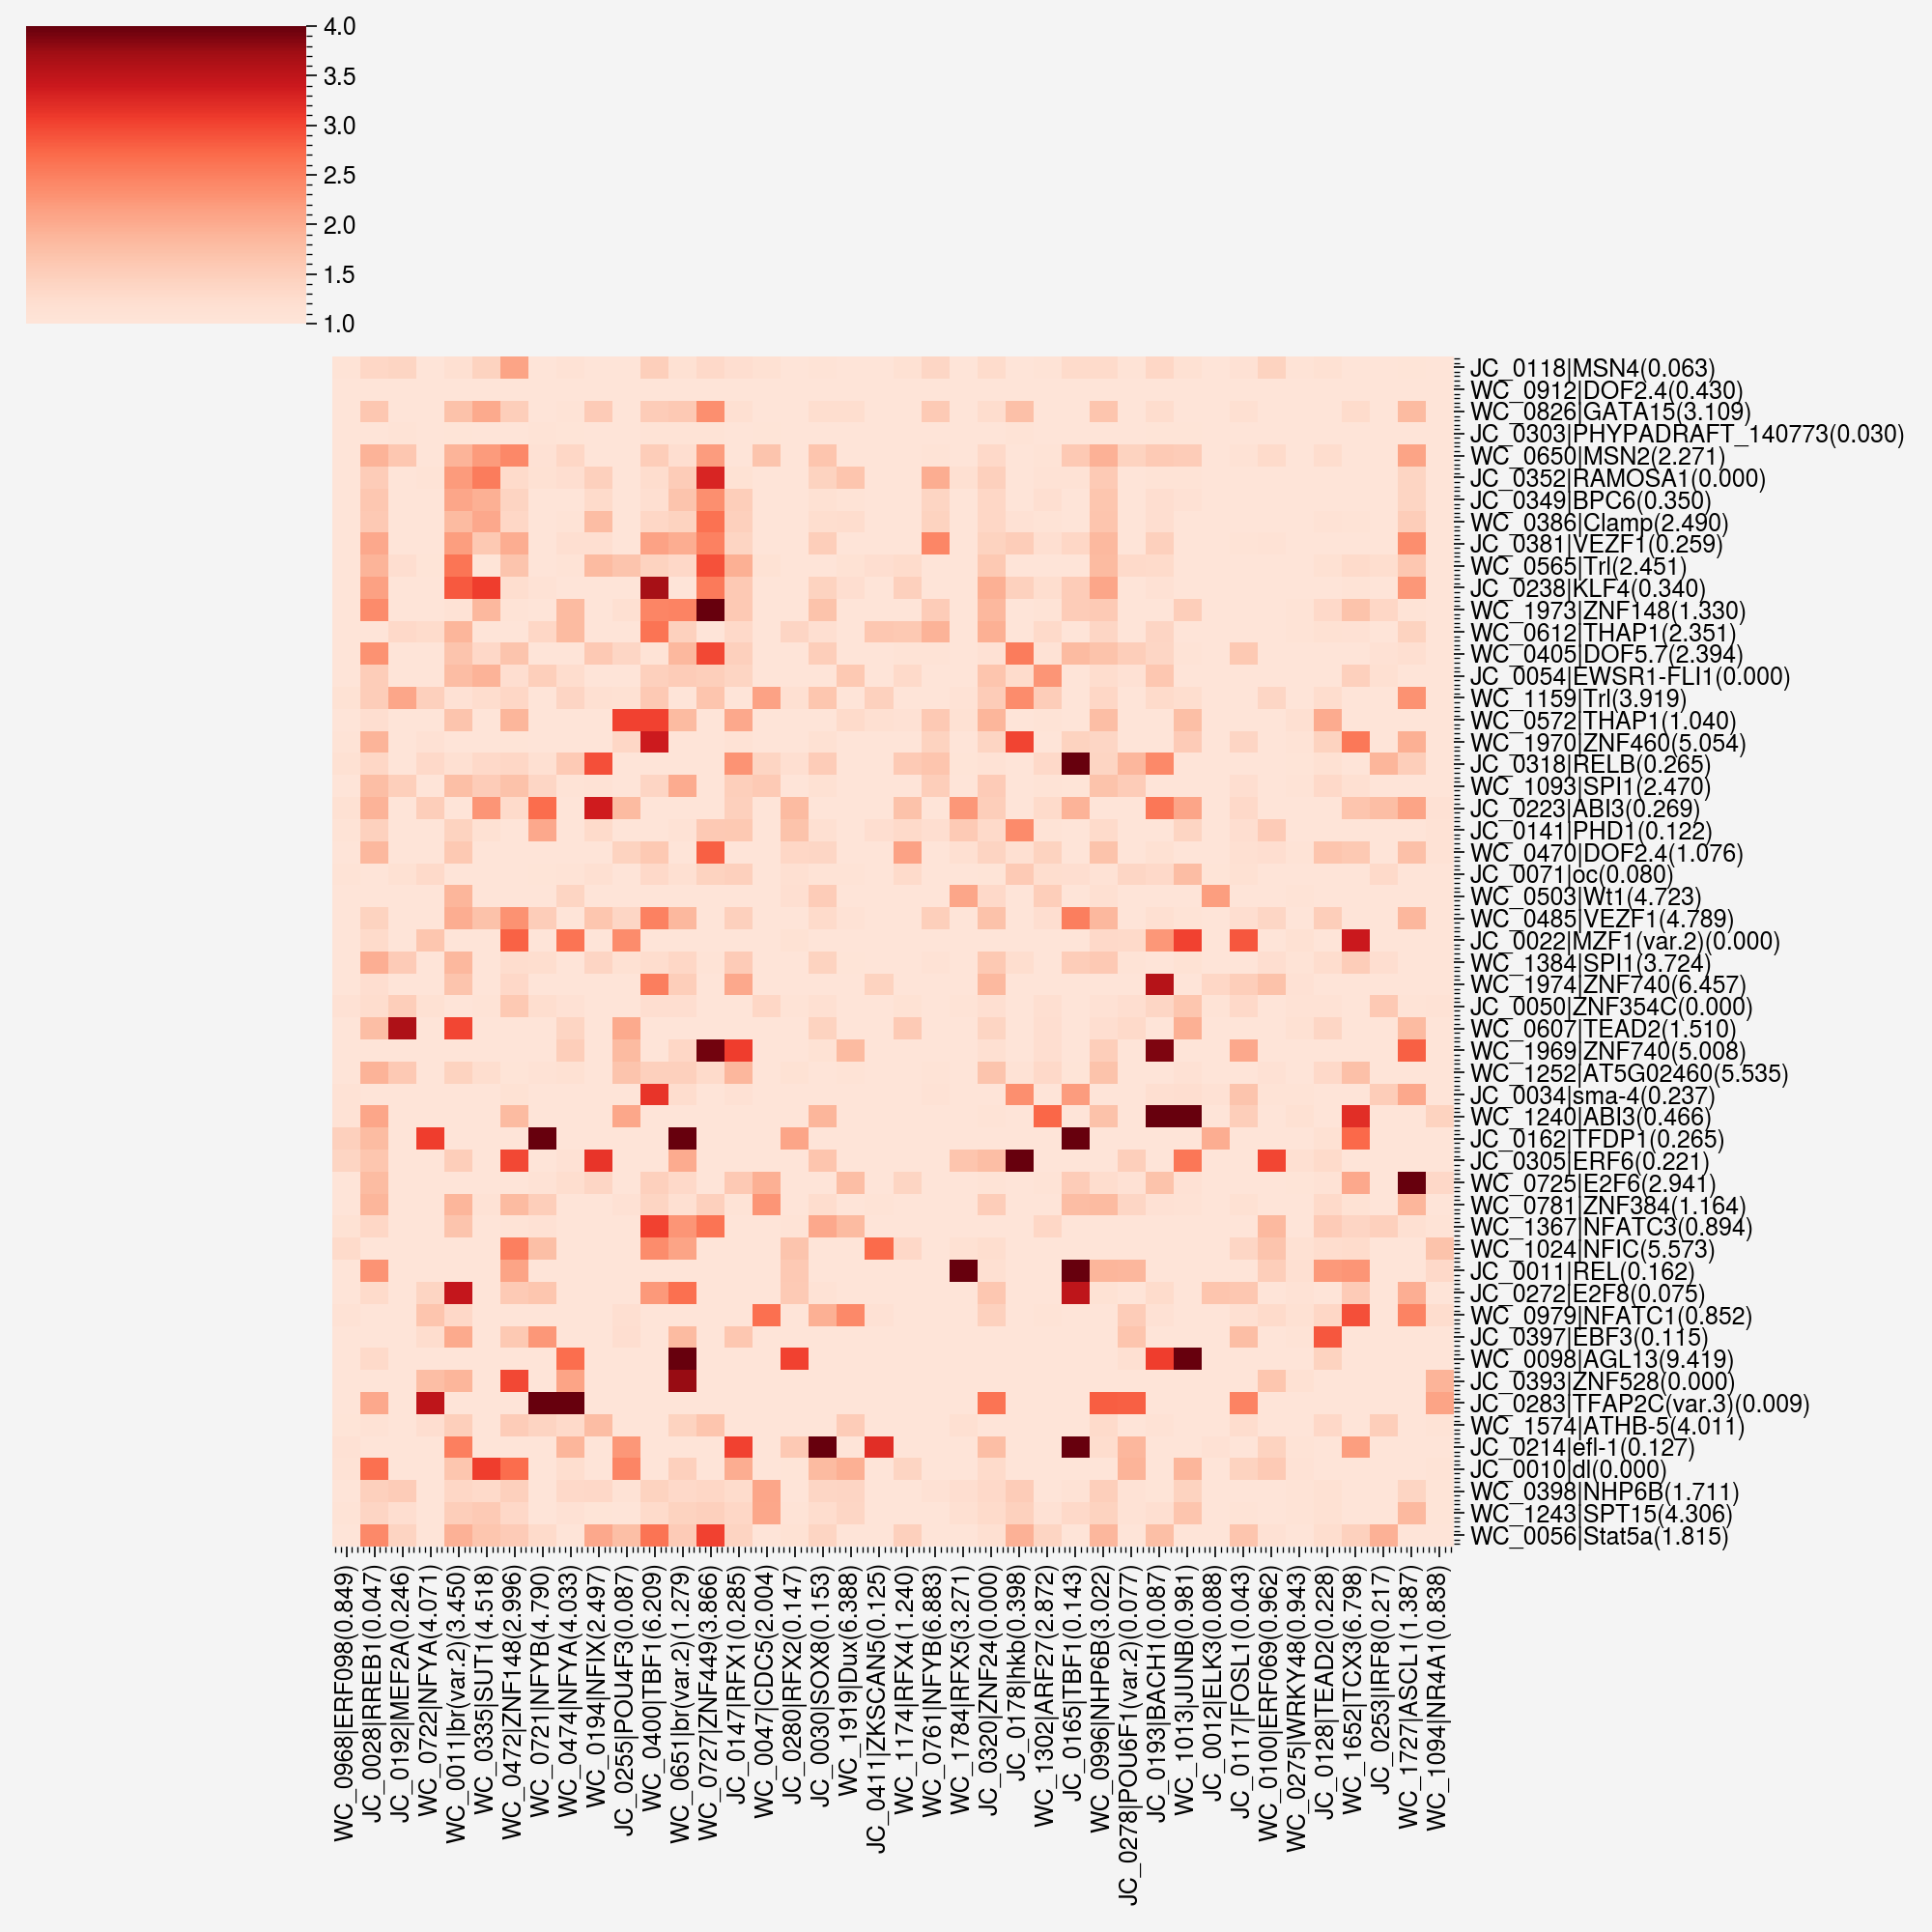

In [79]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Sman_heatmap = sns.clustermap(Sman_neural_muscle,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Sman_heatmap.ax_heatmap.set_xticks(np.arange(Sman_neural_muscle.shape[1])+0.5)
Sman_heatmap.ax_heatmap.set_yticks(np.arange(Sman_neural_muscle.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

Sman_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
Sman_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6e_Sman.svg",format="svg")
plt.show()

### Minimum across  three flatworms

In [80]:
min_merged = np.concatenate((Mlig_neural_muscle[:,:,None],Smed_neural_muscle[:,:,None],Sman_neural_muscle[:,:,None]),axis=2).min(2)

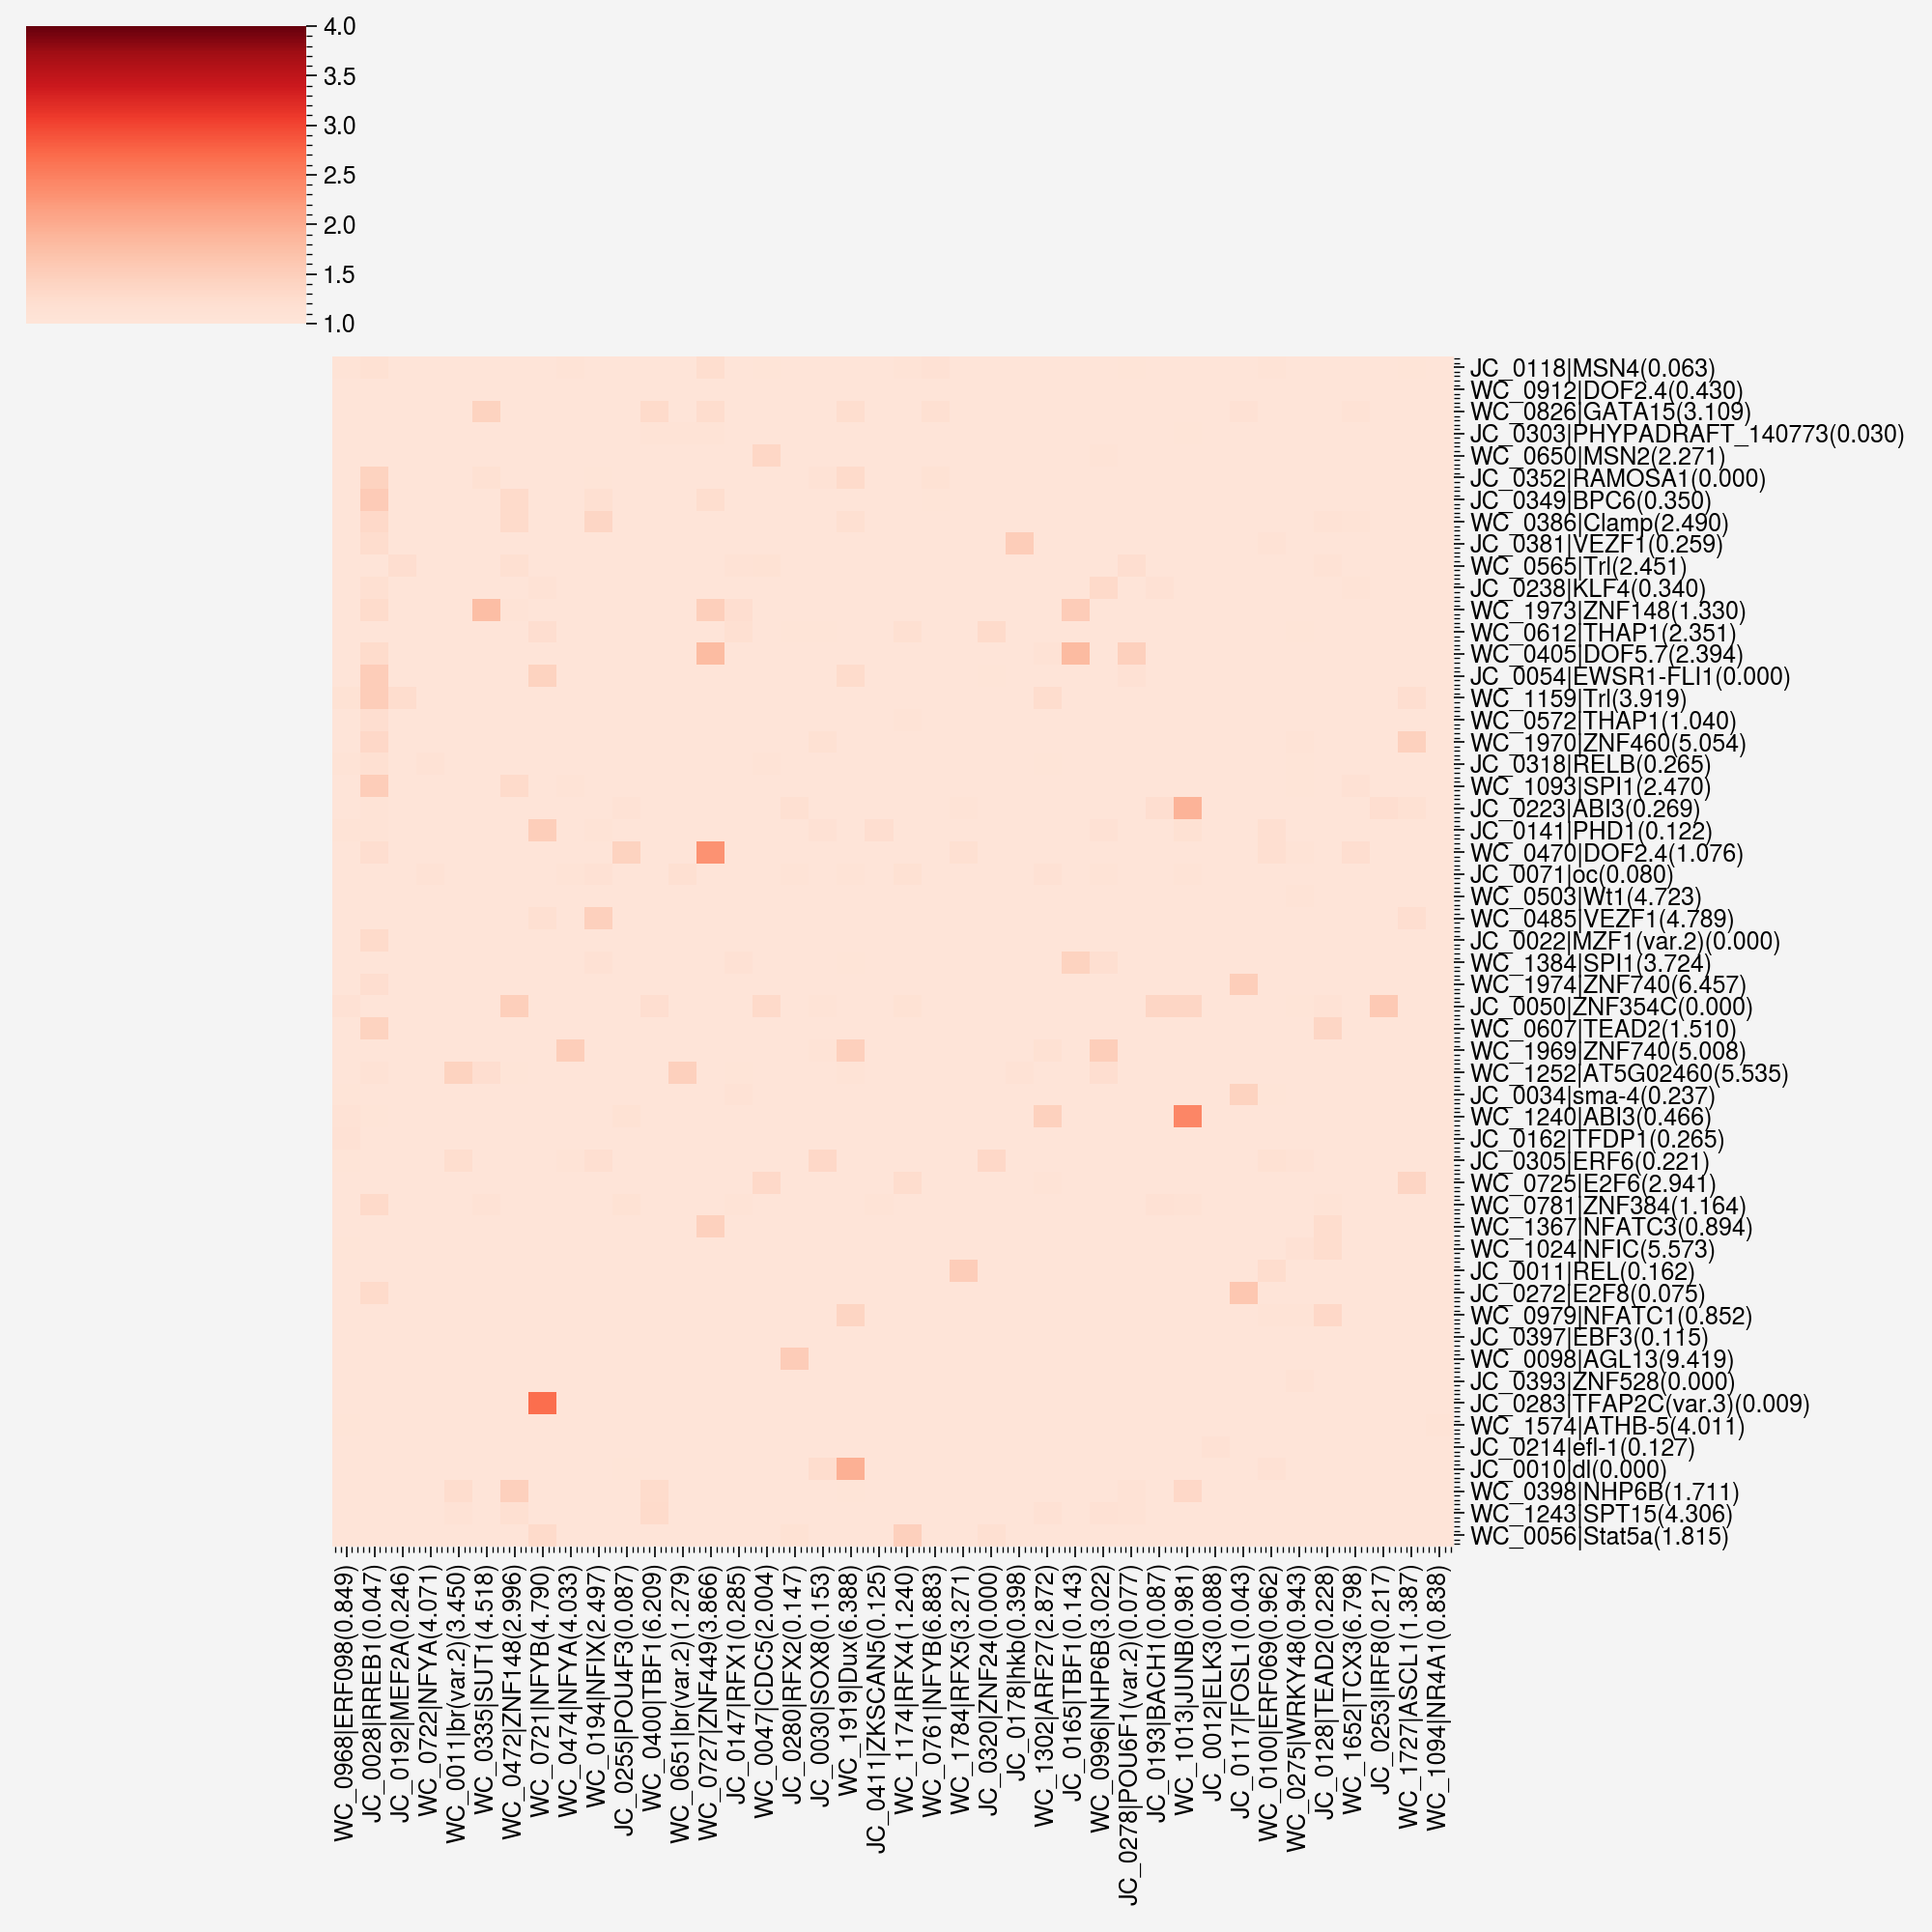

In [81]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
minimum_heatmap = sns.clustermap(min_merged,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
minimum_heatmap.ax_heatmap.set_xticks(np.arange(min_merged.shape[1])+0.5)
minimum_heatmap.ax_heatmap.set_yticks(np.arange(min_merged.shape[0])+0.5)

pan_neural_muscle = Mlig.index
pan_neural_muscle = [res[pan_neural_muscle] for pan_neural_muscle in pan_neural_muscle]
neural_muscle_motifs = Mlig_neural.columns.tolist() + Mlig_muscle.columns.tolist()
neural_muscle_motifs = [res[neural_muscle_motifs] for neural_muscle_motifs in neural_muscle_motifs]

minimum_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
minimum_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig6/PanelED6e_minimum.svg",format="svg")
plt.show()